<a href="https://colab.research.google.com/github/benson85560/TMBA/blob/main/TMBA_%E5%8F%B0%E6%8C%87%E6%9C%9FCTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 匯入資料
* missing data： 2012/01/19~2012/01/29 (1/23過年) 

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests

import datetime as dt
import time
from pandas.core.tools.datetimes import to_datetime
import math as m

path = os.getcwd()
print(path)

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip3 install wheel

In [ ]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.0/272.0 KB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ta-lib: filename=TA_Lib-0.4.25-cp38-cp38-linux_x86_64.whl size=1820820 sha256=00e7964a5a4ccbe39230

In [ ]:
import talib 
from talib import abstract

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TMBA/TWF_Futures_Minute_Trade.txt')

In [ ]:
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time']) # combine date, time
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.map(lambda x: x.hour) # find certain hour 
df.head(3)

# DatetimeIndex: 1971256 entries, 2009-01-05 08:46:00 to 2022-05-23 09:14:00

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8


Text(0.5, 1.0, 'Volume History')

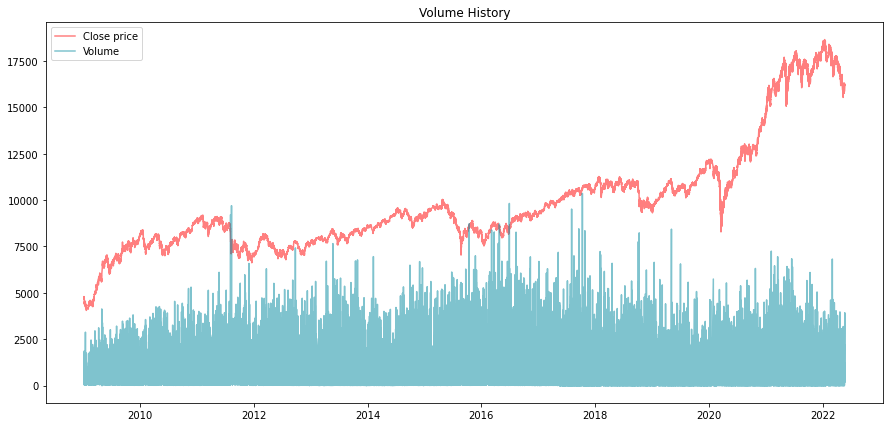

In [ ]:
# view data

plt.figure(figsize = (15,7))
plt.plot(df['close'], color = 'red', alpha = 0.5, label = 'Close price')
plt.plot(df['volume'], color = '#01889f', alpha = 0.5, label = 'Volume')
plt.legend(loc='upper left')
plt.title('Volume History')

# 整理資料
* 時間：小時K

In [ ]:
# morning K

rule = '60T' # 60T

Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15) # avoid resample problem

d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Morning.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Morning = pd.concat([d1,d2,d3,d4,d5], axis=1)


df_Morning = df_Morning.dropna()
df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)
df_Morning.head(3)

,open,high,low,close,volume
2009-01-05 08:45:00,4722.0,4797.0,4692.0,4758.0,27508
2009-01-05 09:45:00,4759.0,4767.0,4710.0,4732.0,15701
2009-01-05 10:45:00,4732.0,4733.0,4634.0,4670.0,25172


In [ ]:
# night K

rule = '60T' # 60T

Night = df[(df['Hour'] < 8) | (df['Hour'] > 13)]

d1 = Night.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Night.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Night.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Night.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Night.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Night = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Night = df_Night.dropna()
df_Night.head(3)

,open,high,low,close,volume
2017-05-15 15:00:00,10023.0,10034.0,10020.0,10033.0,925
2017-05-15 16:00:00,10032.0,10032.0,10028.0,10030.0,300
2017-05-15 17:00:00,10030.0,10030.0,10026.0,10027.0,137


In [ ]:
# merge morning and night

df_Day = pd.concat([df_Morning, df_Night], axis=0)
df_Day = df_Day.sort_index(ascending=True)
df_Day.tail(3)

,open,high,low,close,volume
2022-05-21 03:00:00,15932.0,16108.0,15912.0,16102.0,9886
2022-05-21 04:00:00,16103.0,16174.0,16103.0,16151.0,5092
2022-05-23 08:45:00,16220.0,16263.0,16204.0,16216.0,17891


# 加入指標
* 先做日盤

In [ ]:
# Adding Indicator
data = df_Morning.copy()
data['ADX'] = abstract.ADX(df_Morning, timeperiod = 14)
data['PDI'] = abstract.PLUS_DI(df_Morning, timeperiod = 7) # positive DI
data['NDI'] = abstract.MINUS_DI(df_Morning, timeperiod = 7) # negative DI
data['EMA'] = abstract.EMA(df_Morning, timeperiod = 900) 
data['MACD'] = abstract.MACD(df_Morning, fastperiod=11, slowperiod=40, signalperiod=9)['macd']
data['SAR'] = abstract.SAR(df_Morning, acceleration=0.008, maximum=0.20)
data['RSI'] = abstract.RSI(df_Morning, timeperiod = 14)
data['RSI_MA'] = talib.SMA(data['RSI'], timeperiod=14)

data = data.dropna()
data.head(3)

,open,high,low,close,volume,ADX,PDI,NDI,EMA,MACD,SAR,RSI,RSI_MA
2009-09-23 12:45:00,7325.0,7380.0,7311.0,7347.0,24527,21.567037,14.141711,27.434831,5955.452222,16.154341,7609.009284,39.402513,52.788998
2009-09-24 08:45:00,7364.0,7375.0,7326.0,7340.0,20428,20.823403,12.365765,23.989507,5958.525580,7.098213,7605.769210,38.581952,51.542356
2009-09-24 09:45:00,7340.0,7363.0,7305.0,7325.0,18058,20.583222,10.538200,25.795143,5961.558820,-1.906427,7602.555056,36.812805,49.893606


# 結算日處理

In [ ]:
# settlement day
Set_ = pd.read_csv('/content/drive/MyDrive/TMBA/settlementDate.csv')
Set_.columns = ['settlementDate', 'futures', 'settlementPrice']
Set_.head(3)

,settlementDate,futures,settlementPrice
0,2022/08/03,202208W1,14707
1,2022/07/27,202207W4,14887
2,2022/07/20,202207,14713


In [ ]:
bool_ = [False if 'W' in i else True for i in Set_['futures']] # find settlementDay
settlementDate = [i.replace('/','-') for i in list(Set_[bool_]['settlementDate'])]
settlementDate = [pd.to_datetime(i).date() for i in settlementDate] # change into datetime
settlementDate[0:3]

[datetime.date(2022, 7, 20),
 datetime.date(2022, 6, 15),
 datetime.date(2022, 5, 18)]

In [ ]:
# data['Bool'] = data.index.map(lambda x: x.date)
# data['Bool'] = data['Bool'].isin(settlementDate)
# data = data.loc[-data.Bool]
# data.head()

# 不能把結算日刪除...

In [ ]:
# Settlement 
    # sell2: when settlementDate # 有問題要重新處理
    # if BS == 'B' or BS == 'Ready' and trainData.index[i] in settlementDate:

    #     # delete last profit
    #     timeList.pop(-1)
    #     profit_list.pop(-1)
    #     profit_fee_list.pop(-1)

    #     profit = money * (trainData['close'][i+1] - trainData['close'][i-1]) # ignore settlement day 
    #     profit_list.append(profit)
    #     timeList.append(trainData.index[i])
    #     profit_fee = profit - feePaid * 2 # buy + sell on settlementDay
    #     profit_fee_list.append(profit_fee)
    #     continue

# 選擇回測資料

In [ ]:
trainData = data[(data.index >= '2011-01-01 00:00:00') & (data.index <= '2019-12-31 00:00:00')].copy()
testData = data[(data.index >= '2020-1-1 00:00:00') & (data.index <= '2022-5-22 00:00:00')].copy()
totalData = data[(data.index >= '2011-1-1 00:00:00') & (data.index <= '2022-5-22 00:00:00')].copy()

# 金額與手續費設定

In [ ]:
fund = 1000000
feePaid = 600
feeRate = feePaid/fund
money = fund

# Strategy：Buy n hold
* 做為Benchmark

## 利潤設定

In [ ]:
def bnh_strategy(df):
  global equity
  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0
  temp_0 = 0

  #--------# 記錄買入、賣出時間點
  buy = []
  sell = []
  sell_win = []
  sell_lose = []
  sell_lose2 = []
  #--------# 
  timeList = [] 
  profit_list = [0]
  profit_fee_list = [0]


  for i in range(len(df)):

      if first == 0:
          timeList.append(df.index[i+1])
          first = 1
          continue

      if i == len(df)-1: # last trading day
          break
      

        # record profit
      else:
          profit = money * ((df['close'][i+1] - df['close'][i])  / df['close'][i])
          profit_list.append(profit)
          timeList.append(df.index[i])
      
  equity = pd.DataFrame({'profit':profit_list, 'cum_profit':np.cumsum(profit_list)}, index=timeList)

def bnh_performance(df):
  df['equity'] = df['cum_profit'] + fund
  df['drawdown_percent'] = (df['equity'] / df['equity'].cummax()) - 1
  df['drawdown'] = df['equity'] - df['equity'].cummax()

  ret = (df['equity'].iloc[-1]/fund-1)
  ann_ret = (1 + ret) ** (1/(df.index[-1].year - df.index[1].year)) - 1
  df['drawdown_percent'] = (df['equity'] / df['equity'].cummax()) - 1
  mdd = abs(df['drawdown_percent'].min())
  
  # daily_ret = df['cum_profit'].pct_change(5)[6:]
  # mean_ret = daily_ret.mean()
  # std = daily_ret.std()


  calmarRatio = ret / mdd
  sharpe = df['cum_profit'].mean() / df['cum_profit'].std()


  print(f'total return: {np.round(ret * 100,2)}%')
  print(f'annualized return: {np.round(ann_ret * 100,2)}%')
  print(f'mdd: {np.round(mdd * 100,2)}%')
  print(f'calmar ratio: {np.round(calmarRatio,2)}')
  print(f'sharpe ratio: {np.round(sharpe,4)}')

In [ ]:
ret.resample('1D').sum()

NameError: ignored

In [ ]:
ret = equity_bnh_train['cum_profit']
daily_ret = ret.resample('1D').sum()
daily_ret.mean()/ daily_ret.std()

0.2977831341361808

In [ ]:
ret = equity_bnh_train['cum_profit'].pct_change()[2:]
daily_ret = ret.resample('1D').sum()
daily_ret.mean()/ daily_ret.std() * 252

-4.903976158107672

## result

total return: 38.71%
annualized return: 4.18%
mdd: 29.22%
calmar ratio: 1.32
sharpe ratio: 0.371


Text(0.5, 1.0, 'BnH Strategy return (training)')

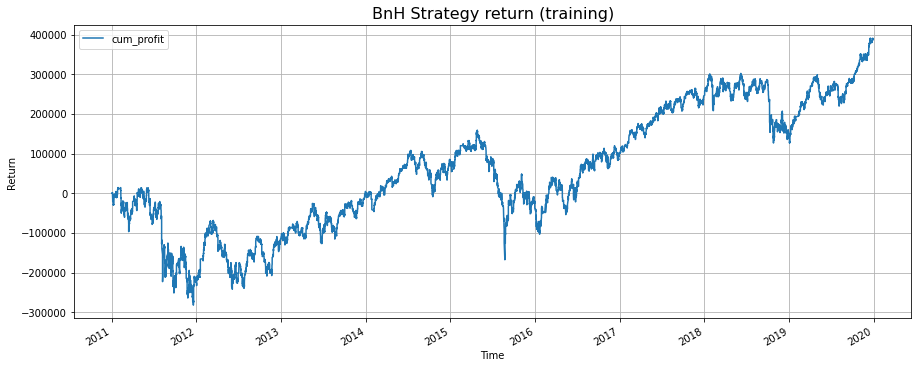

In [ ]:
# train
bnh_strategy(trainData)
equity_bnh_train = equity.copy()
# performance
bnh_performance(equity_bnh_train)
# plot
equity_bnh_train['cum_profit'].plot(grid=True, figsize=(15, 6))
plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('BnH Strategy return (training)',fontsize  = 16)

total return: 33.9%
annualized return: 15.72%
mdd: 36.45%
calmar ratio: 0.93
sharpe ratio: 1.1054


Text(0.5, 1.0, 'BnH Strategy return (testing)')

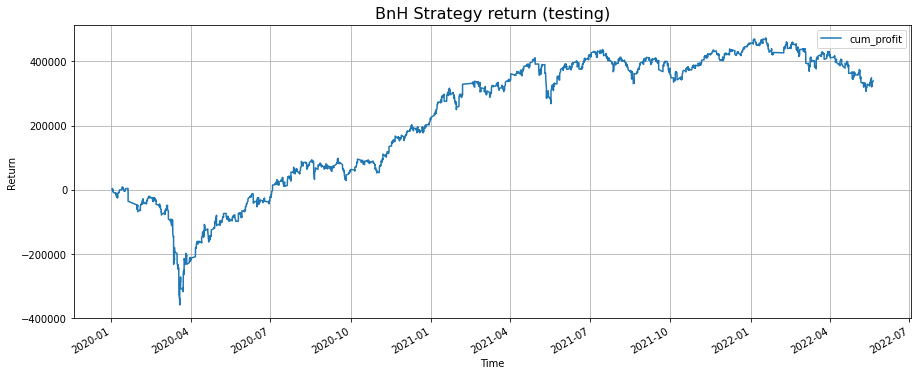

In [ ]:
# test
bnh_strategy(testData)
equity_bnh_test = equity.copy()
# performance
bnh_performance(equity_bnh_test)
# plot
equity_bnh_test['cum_profit'].plot(grid=True, figsize=(15, 6))
plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('BnH Strategy return (testing)',fontsize  = 16)

total return: 72.83%
annualized return: 5.1%
mdd: 29.22%
calmar ratio: 2.49
sharpe ratio: 0.6169


Text(0.5, 1.0, 'BnH Strategy return (all)')

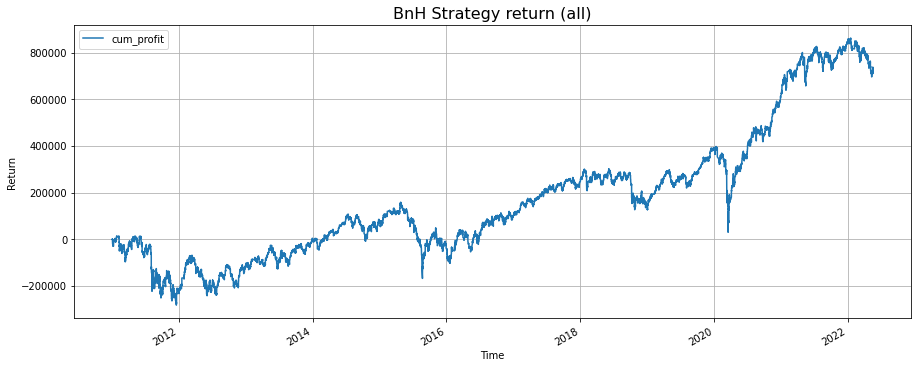

In [ ]:
# all
bnh_strategy(totalData)
equity_bnh_all = equity.copy()
# performance
bnh_performance(equity_bnh_all)
# plot
equity_bnh_all['cum_profit'].plot(grid=True, figsize=(15, 6))
plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('BnH Strategy return (all)',fontsize  = 16)

# Strategy：做多


## 利潤設定

In [ ]:
def sell_profit(sell_price, buy_price, lastday_price, time):
  winLose = sell_price - buy_price

  if winLose > 0:
    sell_win.append(i+1)
  else:
    sell_lose.append(i+1) 
  
  profit = money * ((sell_price - lastday_price) / lastday_price)
  profit_list.append(profit)
  profit_fee = profit - (money+profit) * feeRate - money * feeRate
  profit_fee_list.append(profit_fee)
  timeList.append(time)
  sell.append(i+1)


def record_profit(sell_price, lastday_price, time):
  profit = money * ((sell_price - lastday_price)  / lastday_price)
  profit_list.append(profit)
  profit_fee_list.append(profit)
  timeList.append(time)

sell_win = []
sell_lose = []

def performance(df, index, cum_profit, buy, sell, win = sell_win, lose = sell_lose):

  equity = cum_profit + fund
  drawdown_percent = (equity / equity.cummax()) - 1
  drawdown = equity - equity.cummax()

  ret = (equity.iloc[-1]/fund-1)
  ann_ret = (1 + ret) ** (1/(index[-1].year - index[1].year)) - 1
  mdd = abs(drawdown_percent.min())
  mean_ret = cum_profit.mean()
  std = cum_profit.std()

  # holding period
  duration = []
  if len(buy) == len(sell):
    for i in range(len(buy)):
      x = sell[i] - buy[i]
      duration.append(x)
  else:
    buy_1 = buy[:-1]
    for i in range(len(buy_1)):
      x = sell[i] - buy_1[i]
      duration.append(x)

  avg_hldPeriod = np.array(duration).mean()


  calmarRatio = ret / mdd
  sharpe = cum_profit.mean() / cum_profit.std()
  winRate = len(sell_win)/(len(sell_win) + len(sell_lose))

  print(f'total return: ${np.round(ret * 100,2)}%')
  print(f'annualized return: ${np.round(ann_ret * 100,2)}%')
  print(f'mdd: {np.round(mdd * 100,2)}%')
  print(f'average holding period: {np.round(avg_hldPeriod,2)} hours')
  print(f'calmar ratio: {np.round(calmarRatio,2)}')
  print(f'sharpe ratio: {np.round(sharpe,4)}')
  print(f'win rate: {np.round(winRate * 100,2)}%')


  fig, ax = plt.subplots(figsize = (16,6))

  high_index = df[cum_profit.cummax() == cum_profit].index
  cum_profit.plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
  plt.fill_between(drawdown.index, drawdown, 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
  plt.scatter(high_index, cum_profit.loc[high_index],c = '#02ff0f', label = 'High')

  plt.legend()
  plt.ylabel('Accumulated Profit')
  plt.xlabel('Time')
  plt.title('Profit & Drawdown',fontsize  = 16);




## strategy1: DMI
* 進場條件
1. (NDI > 目標)
2. ADX > 目標
3. 收盤價在EMA之上(900根k棒)
* 出場條件
1. NDI向下穿越PDI(ready)=>再重新向上穿越PDI
* 停損條件
1. 虧損>3%


<ipython-input-140-1232640da814>:57: RuntimeWarning: divide by zero encountered in double_scalars
  stop_loss2 = (trainData['close'][i] - temp_0)/temp_0 < -0.03


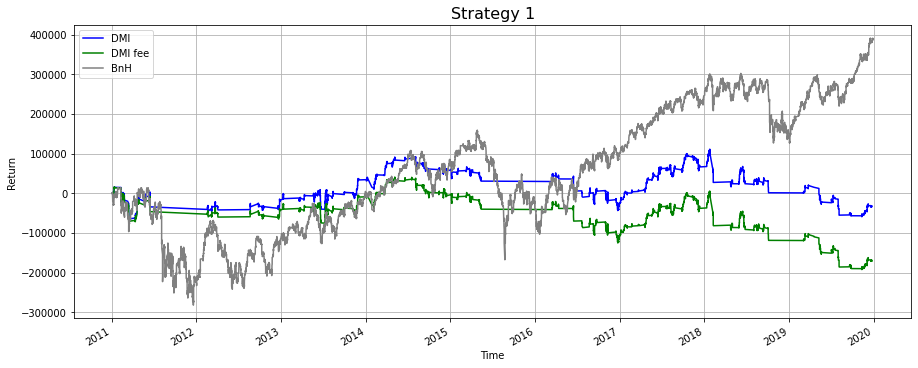

In [ ]:
# strategy1: DMI

first = 0 # 除了第一筆之外，只紀錄出場的時間點
BS = None # 紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0
temp_0 = 0

#--------# 重新載入訓練資料
trainData = data[(data.index >= '2011-01-01 00:00:00') & (data.index <= '2019-12-31 00:00:00')].copy()
#--------# 設定進場標準

# method 1
goal_NDI = np.percentile(trainData['NDI'], 80)
goal_ADX = np.percentile(trainData['ADX'], 50)

# method 2
# percent = 0.85
# rolling_period = 110
# trainData['goal_NDI']  =  percent * trainData['NDI'].rolling(rolling_period).mean()/0.5
# trainData['goal_ADX'] = trainData['ADX'].rolling(rolling_period).mean()
# trainData = trainData.bfill()

#--------# 記錄買入、賣出時間點
buy = []
sell = []
sell_win = []
sell_lose = []
sell_lose2 = []

#--------# 記錄報酬
timeList = [] 
profit_list = [0]
profit_fee_list = [0]



for i in range(len(trainData)):

    # buy condition
    condition1 = (trainData['NDI'][i] > goal_NDI)
    condition2 = (trainData['ADX'][i] > goal_ADX)
    condition4 = (trainData['close'][i] > trainData['EMA'][i])
    # condition6 = (trainData.index[i] not in settlementDate)


    ###---stopearn_NDI---###
    
    # ready
    ready1 = (trainData['PDI'][i] > trainData['NDI'][i])

    # stop earn
    stop_earn1 = (trainData['NDI'][i] > trainData['PDI'][i])

    # stop loss
    # stop_loss1 = (trainData['close'][i] <= trainData['EMA'][i])
    stop_loss2 = (trainData['close'][i] - temp_0)/temp_0 < -0.03


    if first == 0:
        timeList.append(trainData.index[i+1])
        first = 1
        continue

      # last trading day
    if i == len(trainData)-1: 
        break 
     
      # buy 
    if condition1 and condition2 and condition4 and (BS == None):
        BS = 'B' 
        temp_0 = trainData['open'][i+1] 
        buy.append(i+1)
        continue
  
      # Ready
    if ready1 and (BS == 'B'):
        BS = 'Ready' 

      # sell 
    if stop_earn1 and (BS == 'Ready'):
        sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = None
        continue


     # sell_loss: >3%
    if stop_loss2 and (BS == 'Ready' or BS == 'B'): 
        sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = None
        continue
    
      # record profit
    if BS == 'B' or BS == 'Ready':
        record_profit(trainData['close'][i+1], trainData['close'][i], trainData.index[i])


equity = pd.DataFrame({'profit':profit_list, 'cum_profit':np.cumsum(profit_list), 'profit_fee':profit_fee_list, 'cum_profit_fee':np.cumsum(profit_fee_list)}, index=timeList) 

dmi_equity = equity.copy()

# plot
equity['cum_profit'].plot(grid=True, label = 'DMI', c = 'b', figsize=(15, 6));
equity['cum_profit_fee'].plot(grid=True, label = 'DMI fee', c = 'g', figsize=(15, 6));
equity_bnh_train['cum_profit'].plot(grid=True, label = 'BnH', c = 'gray', figsize=(15, 6));

plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('Strategy 1',fontsize  = 16);

### 交易位置試算

In [ ]:
print('buy:{}'.format(len(buy)))
print('sell:{}'.format(len(sell)))
print('sellwin:{}'.format(len(sell_win)))
print('selllose:{}'.format(len(sell_lose)))
print('winlose_ratio:{}'.format(len(sell_win)/len(sell)))

buy:115
sell:115
sellwin:62
selllose:53
winlose_ratio:0.5391304347826087


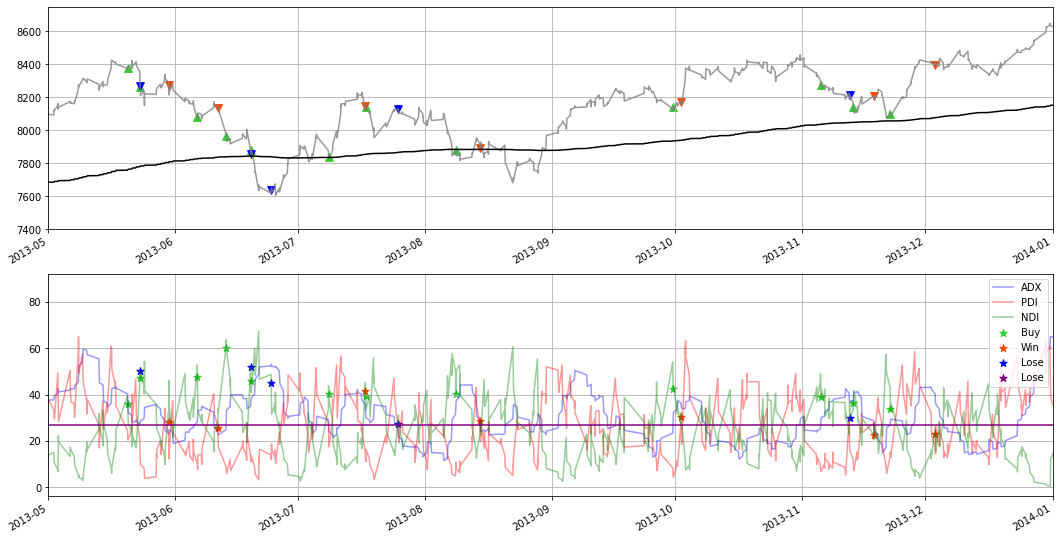

In [ ]:
# visualize trading position

fig, ax = plt.subplots(2, 1, figsize = (18,10))

a = 0
b = 1
# c = 2

# close a
trainData['close'].plot(label = 'close Price', ax = ax[a], c = 'gray', grid=True, alpha=0.8)
trainData['EMA'].plot(label = 'EMA', ax = ax[a], c = 'black', grid=True)
ax[a].scatter(trainData['close'].iloc[buy].index, trainData['close'].iloc[buy], c = 'limegreen', label = 'Buy', marker='^', s=60)
ax[a].scatter(trainData['close'].iloc[sell_win].index, trainData['close'].iloc[sell_win], c = 'orangered', label = 'Win', marker='v', s=60)
ax[a].scatter(trainData['close'].iloc[sell_lose].index, trainData['close'].iloc[sell_lose], c = 'b', label = 'Lose', marker='v', s=60)
# ax[a].scatter(trainData['close'].iloc[sell_lose2].index, trainData['close'].iloc[sell_lose2], c = 'purple', label = 'Lose2', marker='v', s=60)


# DMI b
trainData['ADX'].plot(label = 'ADX', ax = ax[b], c = 'b', grid=True, alpha=0.4)
trainData['PDI'].plot(label = 'PDI', ax = ax[b], c = 'r', grid=True, alpha=0.4)
trainData['NDI'].plot(label = 'NDI', ax = ax[b], c = 'g', grid=True, alpha=0.4)
ax[b].scatter(trainData['close'].iloc[buy].index, trainData['NDI'].iloc[buy], c = 'limegreen', label = 'Buy', marker='*', s=60)
ax[b].scatter(trainData['close'].iloc[sell_win].index, trainData['NDI'].iloc[sell_win], c = 'orangered', label = 'Win', marker='*', s=60)
ax[b].scatter(trainData['close'].iloc[sell_lose].index, trainData['NDI'].iloc[sell_lose], c = 'b', label = 'Lose', marker='*', s=60)
ax[b].scatter(trainData['close'].iloc[sell_lose2].index, trainData['NDI'].iloc[sell_lose2], c = 'purple', label = 'Lose', marker='*', s=60)
ax[b].axhline(goal_ADX, c = 'purple')

# # MACD c
# trainData['MACD'].plot(label = 'MACD', ax = ax[c], c = 'black', grid=True)
# ax[c].axhline(y = 0)
# ax[c].scatter(trainData['close'].iloc[buy].index, trainData['MACD'].iloc[buy], c = 'limegreen', label = 'Buy', marker='*', s=60)
# ax[c].scatter(trainData['close'].iloc[sell_win].index, trainData['MACD'].iloc[sell_win], c = 'orangered', label = 'Win', marker='*', s=60)
# ax[c].scatter(trainData['close'].iloc[sell_lose].index, trainData['MACD'].iloc[sell_lose], c = 'b', label = 'Lose', marker='*', s=60)
# ax[c].scatter(trainData['close'].iloc[sell_lose2].index, trainData['MACD'].iloc[sell_lose2], c = 'purple', label = 'Lose', marker='*', s=60)


period = '2013-05-01', '2014-01-01'
price = 7400, 8750

ax[a].set_xlim(period)
ax[b].set_xlim(period)
# ax[c].set_xlim(period)

ax[a].set_ylim(price)
# ax[c].set_ylim(-200, 200)

plt.legend(loc = 'upper right')
# plt.ylabel('Index')
# plt.xlabel('Time')
# plt.title('Price Movement',fontsize  = 16)


total return: $-3.34%
annualized return: $-0.42%
mdd: 15.33%
average holding period: 20.69 hours
calmar ratio: -0.22
sharpe ratio: 0.5197
win rate: 53.91%


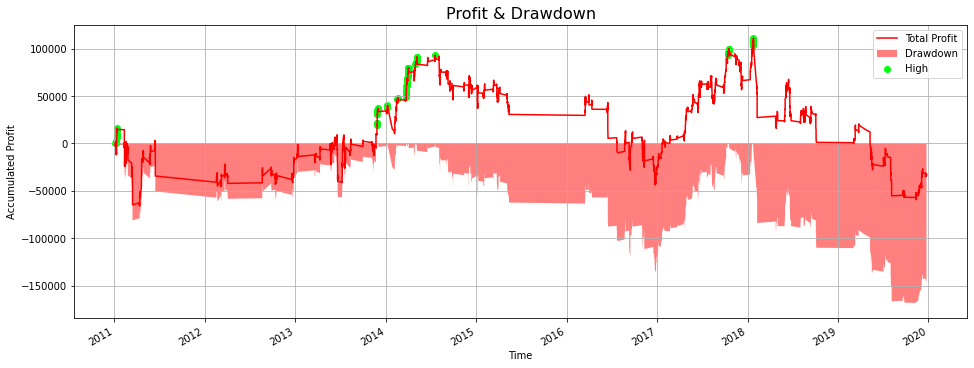

In [ ]:
# 未實現損益 performance
performance(equity, equity.index, equity['cum_profit'], buy, sell)

total return: $-17.14%
annualized return: $-2.32%
mdd: 22.42%
average holding period: 20.69 hours
calmar ratio: -0.76
sharpe ratio: -1.0283
win rate: 53.91%


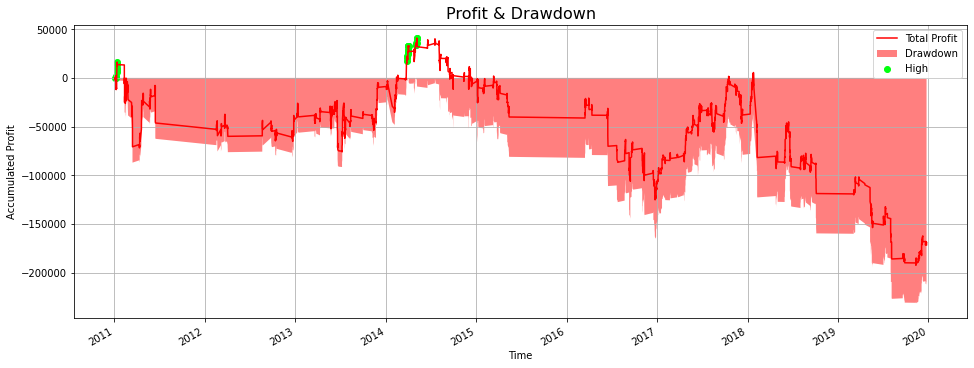

In [ ]:
# 已實現損益 performance
performance(equity, equity.index, equity['cum_profit_fee'], buy, sell)

In [ ]:
dmi_equity['cum_profit'].pct_change(5)[6:].mean()

-0.38411649218058286

## strategy2: SAR
* 進場條件
1. close > SAR
2. close > EMA
* 出場條件
1. close < SAR
2. NDI < goal_NDI
* 停損條件
1. close < EMA


<ipython-input-146-812181b927c7>:45: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  condition4 = (trainData.index[i] not in settlementDate)


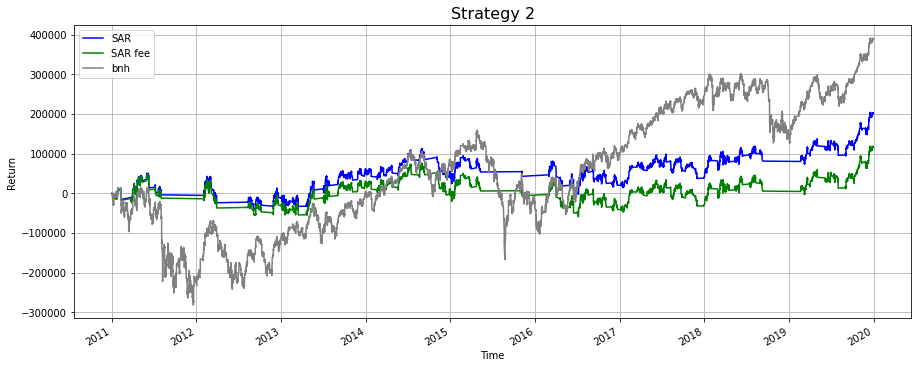

In [ ]:
# strategy2: SAR
#--------# 重新載入訓練資料
trainData = data[(data.index >= '2011-01-01 00:00:00') & (data.index <= '2019-12-31 00:00:00')].copy()
trainData['SAR_new'] = abstract.SAR(trainData, acceleration=0.001, maximum=0.20)

first = 0 # 除了第一筆之外，只紀錄出場的時間點
BS = None # 紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0
temp_0 = 0


#--------# 設定進場標準
# method 1
goal_NDI = np.percentile(trainData['NDI'], 5)
goal_ADX = np.percentile(trainData['ADX'], 50)

# method 2
# percent = 0.85
# rolling_period = 110
# trainData['goal_NDI']  =  percent * trainData['NDI'].rolling(rolling_period).mean()/0.5
# trainData['goal_ADX'] = trainData['ADX'].rolling(rolling_period).mean()
# trainData = trainData.bfill()

#--------# 記錄買入、賣出時間點
buy = []
sell = []
sell_win = []
sell_lose = []
sell_lose2 = []

#--------# 記錄報酬
timeList = [] 
profit_list = [0]
profit_fee_list = [0]



for i in range(len(trainData)):

    # buy condition
    condition1 = (trainData['SAR_new'][i] < trainData['close'][i])
    # condition2 = (trainData['NDI'][i] > goal_NDI)
    condition3 = (trainData['close'][i] > trainData['EMA'][i])
    condition4 = (trainData.index[i] not in settlementDate)   

    # stop earn/loss
    stop1 = (trainData['SAR_new'][i] > trainData['close'][i])
    stop2 = (trainData['close'][i] <= trainData['EMA'][i])
    # stop3 = (trainData['NDI'][i] < goal_NDI)
    
    if first == 0:
        timeList.append(trainData.index[i+1])
        first = 1
        continue

      # last trading day
    if i == len(trainData)-1: 
        break 

    #   #stop3 status
    # if stop1 and BS == 'M':
    #     BS = None
     
      # buy 
    if condition1 and condition3 and BS == None:
        BS = 'B' 
        temp_0 = trainData['close'][i+1] 
        buy.append(i+1)
        continue

      # sell1
    if (stop1 or stop2) and BS == 'B':
        sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = None
        continue     

    # if stop3 and BS == 'B':
    #     winLose = trainData['close'][i+1] - temp_0

    #     if winLose > 0:
    #       sell_win.append(i+1)
    #     else:
    #       sell_lose.append(i+1) 
        
    #     profit = money * ((trainData['close'][i+1] - trainData['close'][i]) / trainData['close'][i])
    #     profit_list.append(profit)
    #     timeList.append(trainData.index[i])
       
    #     sell.append(i+1)
    #     BS = 'M'
    #     continue
     
      # record profit
    if BS == 'B':
        record_profit(trainData['close'][i+1], trainData['close'][i], trainData.index[i])


equity = pd.DataFrame({'profit':profit_list, 'cum_profit':np.cumsum(profit_list), 'profit_fee':profit_fee_list, 'cum_profit_fee':np.cumsum(profit_fee_list)}, index=timeList) 
sar_equity = equity.copy()

# plot
equity['cum_profit'].plot(grid=True, label = 'SAR', c = 'b', figsize=(15, 6));
equity['cum_profit_fee'].plot(grid=True, label = 'SAR fee', c = 'g', figsize=(15, 6));
equity_bnh_train['cum_profit'].plot(grid=True, label = 'bnh', c = 'gray', figsize=(15, 6));

plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('Strategy 2',fontsize  = 16);

### 交易位置試算

In [ ]:
print('buy:{}'.format(len(buy)))
print('sell:{}'.format(len(sell)))
print('sellwin:{}'.format(len(sell_win)))
print('selllose:{}'.format(len(sell_lose)))
print('selllose:{}'.format(len(sell_lose)))
print('winlose_ratio:{}'.format(len(sell_win)/len(sell)))

buy:72
sell:71
sellwin:28
selllose:43
selllose:43
winlose_ratio:0.39436619718309857


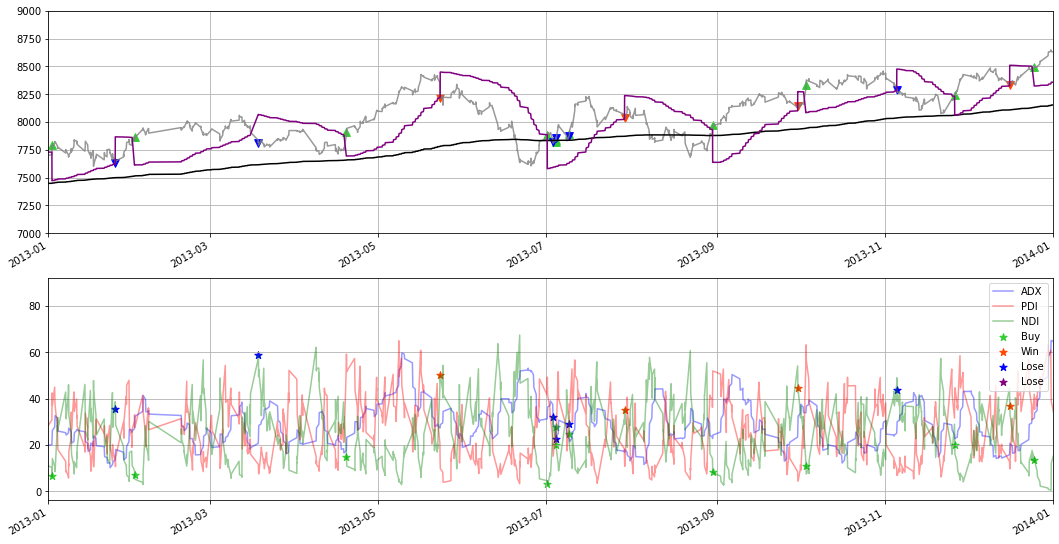

In [ ]:
# visualize trading position

fig, ax = plt.subplots(2, 1, figsize = (18,10))

a = 0
b = 1
c = 3
d = 2

# close a
trainData['close'].plot(label = 'close Price', ax = ax[a], c = 'gray', grid=True, alpha=0.8)
trainData['EMA'].plot(label = 'EMA', ax = ax[a], c = 'black', grid=True)
trainData['SAR_new'].plot(label = 'SAR_new', ax = ax[a], c = 'purple', grid=True)
ax[a].scatter(trainData['close'].iloc[buy].index, trainData['close'].iloc[buy], c = 'limegreen', label = 'Buy', marker='^', s=60)
ax[a].scatter(trainData['close'].iloc[sell_win].index, trainData['close'].iloc[sell_win], c = 'orangered', label = 'Win', marker='v', s=60)
ax[a].scatter(trainData['close'].iloc[sell_lose].index, trainData['close'].iloc[sell_lose], c = 'b', label = 'Lose', marker='v', s=60)
# ax[a].scatter(trainData['close'].iloc[sell_lose2].index, trainData['close'].iloc[sell_lose2], c = 'purple', label = 'Lose2', marker='v', s=60)

# DMI b
trainData['ADX'].plot(label = 'ADX', ax = ax[b], c = 'b', grid=True, alpha=0.4)
trainData['PDI'].plot(label = 'PDI', ax = ax[b], c = 'r', grid=True, alpha=0.4)
trainData['NDI'].plot(label = 'NDI', ax = ax[b], c = 'g', grid=True, alpha=0.4)
ax[b].scatter(trainData['close'].iloc[buy].index, trainData['NDI'].iloc[buy], c = 'limegreen', label = 'Buy', marker='*', s=60)
ax[b].scatter(trainData['close'].iloc[sell_win].index, trainData['NDI'].iloc[sell_win], c = 'orangered', label = 'Win', marker='*', s=60)
ax[b].scatter(trainData['close'].iloc[sell_lose].index, trainData['NDI'].iloc[sell_lose], c = 'b', label = 'Lose', marker='*', s=60)
ax[b].scatter(trainData['close'].iloc[sell_lose2].index, trainData['NDI'].iloc[sell_lose2], c = 'purple', label = 'Lose', marker='*', s=60)

# MACD c
# trainData['MACD'].plot(label = 'MACD', ax = ax[c], c = 'black', grid=True)
# ax[c].axhline(y = 0)
# ax[c].scatter(trainData['close'].iloc[buy].index, trainData['MACD'].iloc[buy], c = 'limegreen', label = 'Buy', marker='*', s=60)
# ax[c].scatter(trainData['close'].iloc[sell_win].index, trainData['MACD'].iloc[sell_win], c = 'orangered', label = 'Win', marker='*', s=60)
# ax[c].scatter(trainData['close'].iloc[sell_lose].index, trainData['MACD'].iloc[sell_lose], c = 'b', label = 'Lose', marker='*', s=60)
# ax[c].scatter(trainData['close'].iloc[sell_lose2].index, trainData['MACD'].iloc[sell_lose2], c = 'purple', label = 'Lose', marker='*', s=60)

# SAR d
# trainData['close'].plot(label = 'close Price', ax = ax[d], c = 'gray', grid=True, alpha=0.8)
# trainData['SAR'].plot(label = 'MACD', ax = ax[d], c = 'purple', grid=True)
# ax[d].scatter(trainData['close'].iloc[buy].index, trainData['SAR'].iloc[buy], c = 'limegreen', label = 'Buy', marker='*', s=60)
# ax[d].scatter(trainData['close'].iloc[sell_win].index, trainData['SAR'].iloc[sell_win], c = 'orangered', label = 'Win', marker='*', s=60)
# ax[d].scatter(trainData['close'].iloc[sell_lose].index, trainData['SAR'].iloc[sell_lose], c = 'b', label = 'Lose', marker='*', s=60)
# ax[d].scatter(trainData['close'].iloc[sell_lose2].index, trainData['SAR'].iloc[sell_lose2], c = 'purple', label = 'Lose', marker='*', s=60)


period = '2013-01-01', '2014-01-01'
price = 7000, 9000

ax[a].set_xlim(period)
ax[b].set_xlim(period)
# ax[c].set_xlim(period)
# ax[d].set_xlim(period)
ax[a].set_ylim(price)
# ax[d].set_ylim(price)
# ax[c].set_ylim(-200, 200)

plt.legend(loc = 'upper right')
# plt.ylabel('Index')
# plt.xlabel('Time')
# plt.title('Price Movement',fontsize  = 16)


total return: $20.0%
annualized return: $2.31%
mdd: 10.36%
average holding period: 71.94 hours
calmar ratio: 1.93
sharpe ratio: 1.3256
win rate: 39.44%


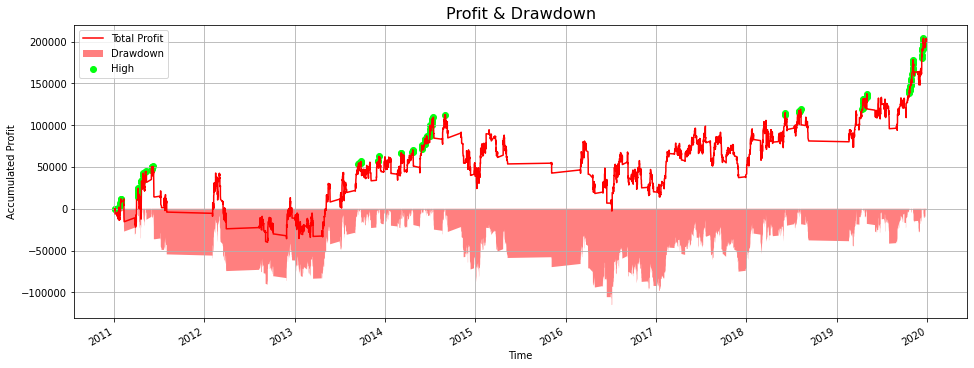

In [ ]:
# 未實現損益 performance
performance(equity, equity.index, equity['cum_profit'], buy, sell)

total return: $11.48%
annualized return: $1.37%
mdd: 12.51%
average holding period: 71.94 hours
calmar ratio: 0.92
sharpe ratio: 0.376
win rate: 39.44%


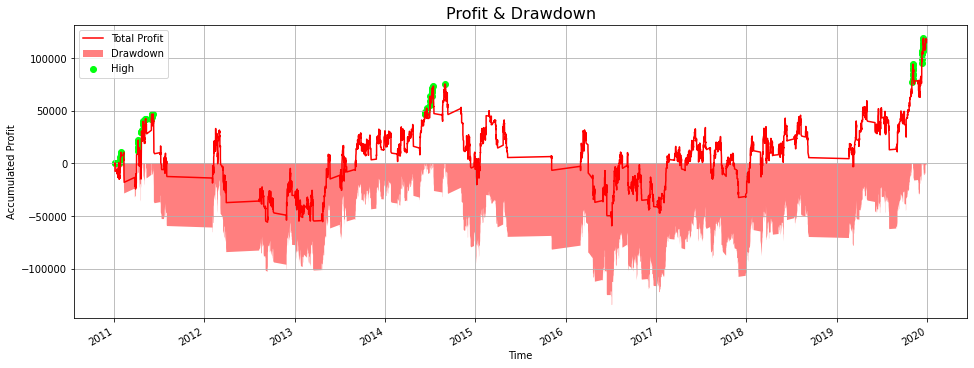

In [ ]:
# 已實現損益 performance
performance(equity, equity.index, equity['cum_profit_fee'], buy, sell)

## Strategy3: RSI + SAR
* 設定進場標準：lower bound

準備進場
* RSI < lower bound
* RSI > RSI_MA
* close > EMA

進場時機
* RSI > lower bound

出場條件
* SAR > close
* close < EMA

崩跌進場
* if MACD < -200, 則就算在EMA下也可以進場


<ipython-input-151-6bca9854d293>:56: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ready4 = (trainData.index[i] not in settlementDate)


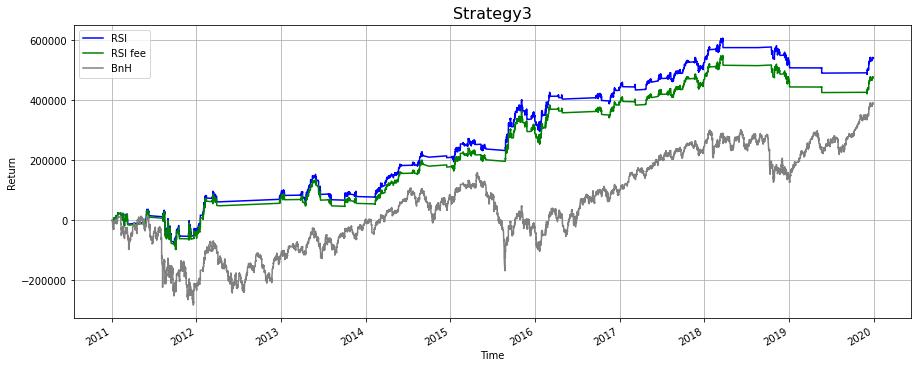

In [ ]:
# strategy3: RSI+SAR

first = 0 # 除了第一筆之外，只紀錄出場的時間點
BS = None # 紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0
temp_0 = 0

#--------# opt result
opt_acc = 0.0025
opt_low = 27
opt_up = 94 # not good

#--------# adding indicator
data_opt = df_Morning.copy()
data_opt['EMA'] = abstract.EMA(df_Morning, timeperiod = 900) 
data_opt['RSI'] = abstract.RSI(df_Morning, timeperiod = 14)
data_opt['RSI_MA'] = talib.SMA(data_opt['RSI'], timeperiod=14)
data_opt['MACD'] = abstract.MACD(df_Morning, fastperiod=11, slowperiod=40, signalperiod=9)['macd']
#========# 最佳化因子
opt_acc = 0.0025
data_opt['SAR'] = abstract.SAR(df_Morning, acceleration = opt_acc, maximum=0.20)
#========#
data_opt = data_opt.dropna()
trainData = data_opt[(data_opt.index >= '2011-01-01 00:00:00') & (data_opt.index <= '2019-12-31 00:00:00')].copy()




#--------# 設定進場標準
lower_bond = np.percentile(trainData['RSI'], opt_low)
upper_bond = np.percentile(trainData['RSI'], opt_up)

#--------# 記錄買入、賣出時間點
buy = []
sell = []
sell_win = []
sell_lose = []
M_point = []

#--------# 記錄報酬
timeList = [] 
profit_list = [0]
profit_fee_list = [0]



for i in range(len(trainData)):

    ###---Buy---###

    # buy ready
    ready1 = (trainData['RSI'][i] < lower_bond)
    ready2 = (trainData['RSI'][i] > trainData['RSI_MA'][i])
    ready3 = (trainData['close'][i] > trainData['EMA'][i])
    ready4 = (trainData.index[i] not in settlementDate)
    # buy 
    buy1 = (trainData['RSI'][i] >= lower_bond)


    ###---turned---###
    
    # sar turnover => BS = 'T'
    turn = (trainData['SAR'][i] < trainData['close'][i])

    ###---sell---###

    # sell
    sell1 = (trainData['SAR'][i] > trainData['close'][i])
    sell2 = (trainData['RSI'][i] > upper_bond and trainData['RSI'][i] < trainData['RSI_MA'][i]) # not good

    # stop loss
    stop_loss1 = (trainData['close'][i] <= trainData['EMA'][i])
    # stop_loss2 = (trainData['close'][i] - temp_0)/temp_0 < -0.03

    # black swawn
    black_swawn = (trainData['MACD'][i] < -200)
    



    if first == 0:
        timeList.append(trainData.index[i+1])
        first = 1
        continue

    if i == len(trainData)-1: 
        break 
     
      # ready to buy 
    if ready1 and ready2 and ready3 and ready4 and BS == None:
        BS = 'R' 
        continue 

      # buy
    if buy1 and BS == 'R':
        temp_0 = trainData['close'][i+1] 
        buy.append(i+1)
        BS = 'B'
        continue
  
      # sar turnover
    if turn and (BS == 'B'):
        BS = 'T' 
        continue

      # sell
    if (sell1) and (BS == 'T'):
        sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = None
        continue


     # sell_loss
    if stop_loss1 and (BS == 'T' or BS == 'B'): 
        sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = None
        continue

    ##### black_swawn #####
    if black_swawn and stop_loss1 and BS == None:
        M_point.append(i)
        BS = 'BS'

    if ready1 and ready2 and ready4 and BS == 'BS':
        BS = 'BS_R' 
        continue 

    if buy1 and BS == 'BS_R':
        temp_0 = trainData['close'][i+1] 
        buy.append(i+1)
        BS = 'BS_B'
        continue

    if turn and (BS == 'BS_B'):
        BS = 'BS_T' 

      # sell
    if (sell1) and (BS == 'BS_T'):
        sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = 'BS'
        continue
         
      # if back to > EMA
    if ready3 and (BS == 'BS' or BS == 'BS_R'):
        BS = None
        continue

    # if ready3 and (BS == 'BS_B'):
    #     BS = 'B'
    #     continue

    # if ready3 and (BS == 'BS_T'):
    #     BS = 'T'
    #     continue
        
    ##### black_swawn #####



      # record profit
    if BS == 'B' or BS == 'T' or BS == 'BS_B' or BS == 'BS_T':
        record_profit(trainData['close'][i+1], trainData['close'][i], trainData.index[i])

    
equity = pd.DataFrame({'profit':profit_list, 'cum_profit':np.cumsum(profit_list), 'profit_fee':profit_fee_list, 'cum_profit_fee':np.cumsum(profit_fee_list)}, index=timeList) 
rsi_equity = equity.copy()

# plot
equity['cum_profit'].plot(grid=True, label = 'RSI', c = 'b', figsize=(15, 6));
equity['cum_profit_fee'].plot(grid=True, label = 'RSI fee', c = 'g', figsize=(15, 6));
equity_bnh_train['cum_profit'].plot(grid=True, label = 'BnH', c = 'gray', figsize=(15, 6));

plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('Strategy3',fontsize  = 16);

### 交易位置試算

In [ ]:
print('buy:{}'.format(len(buy)))
print('sell:{}'.format(len(sell)))
print('sellwin:{}'.format(len(sell_win)))
print('selllose:{}'.format(len(sell_lose)))
print('winlose_ratio:{}'.format(len(sell_win)/len(sell)))

buy:55
sell:54
sellwin:25
selllose:29
winlose_ratio:0.46296296296296297


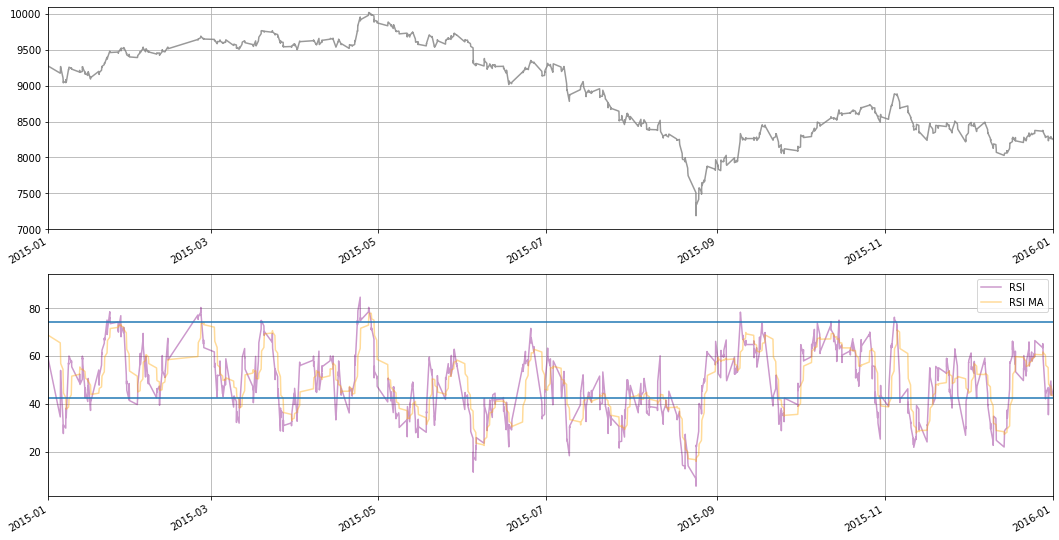

In [ ]:
# visualize trading position

fig, ax = plt.subplots(2, 1, figsize = (18,10))

a = 0
b = 1

# close a
trainData['close'].plot(label = 'close Price', ax = ax[a], c = 'gray', grid=True, alpha=0.8)

# RSI b
trainData['RSI'].plot(label = 'RSI', ax = ax[b], c = 'purple', grid=True, alpha=0.4)
trainData['RSI_MA'].plot(label = 'RSI MA', ax = ax[b], c = 'orange', grid=True, alpha=0.4)
ax[b].axhline(upper_bond)
ax[b].axhline(lower_bond)

period = '2015-01-01', '2016-01-01'
price = 7000, 10100

ax[a].set_xlim(period)
ax[b].set_xlim(period)
ax[a].set_ylim(price)

plt.legend(loc = 'upper right')
# plt.ylabel('Index')
# plt.xlabel('Time')
# plt.title('Price Movement',fontsize  = 16)


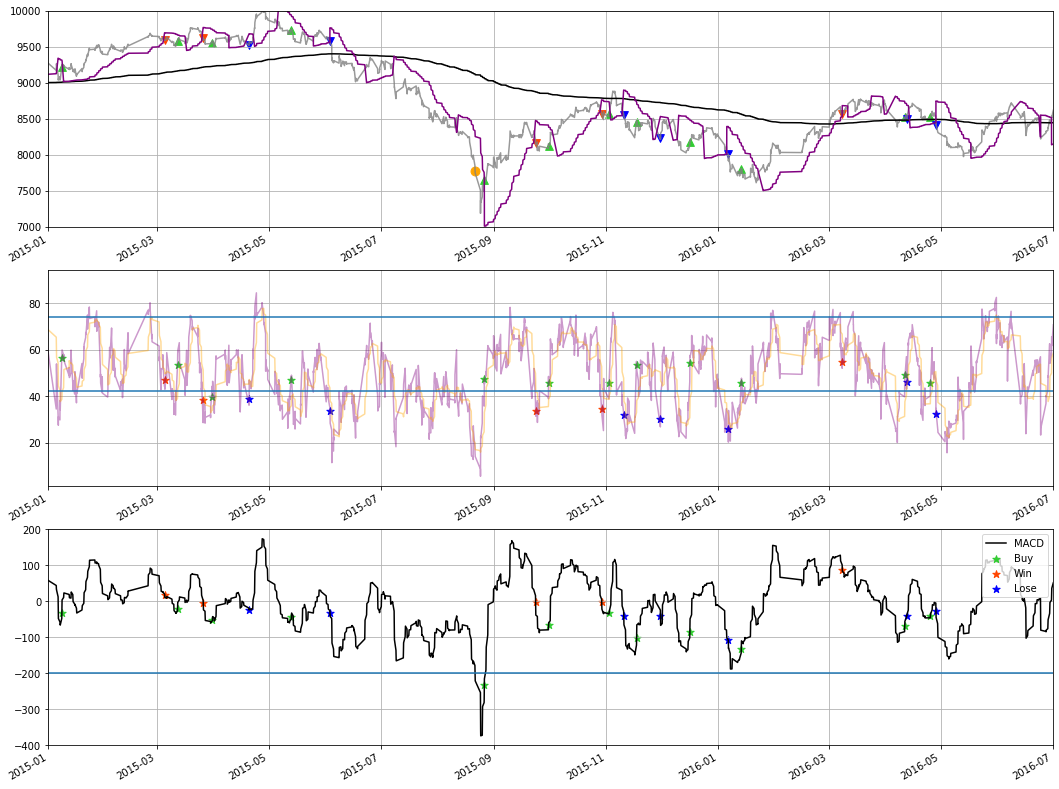

In [ ]:
# visualize trading position

fig, ax = plt.subplots(3, 1, figsize = (18,15))

a = 0
b = 1
c = 2

# close a
trainData['close'].plot(label = 'close Price', ax = ax[a], c = 'gray', grid=True, alpha=0.8)
trainData['EMA'].plot(label = 'EMA', ax = ax[a], c = 'black', grid=True)
trainData['SAR'].plot(label = 'SAR', ax = ax[a], c = 'purple', grid=True)
ax[a].scatter(trainData['close'].iloc[M_point].index, trainData['close'].iloc[M_point], c = 'orange', label = 'Black swawn', marker='o', s=80)
ax[a].scatter(trainData['close'].iloc[buy].index, trainData['close'].iloc[buy], c = 'limegreen', label = 'Buy', marker='^', s=60)
ax[a].scatter(trainData['close'].iloc[sell_win].index, trainData['close'].iloc[sell_win], c = 'orangered', label = 'Win', marker='v', s=60)
ax[a].scatter(trainData['close'].iloc[sell_lose].index, trainData['close'].iloc[sell_lose], c = 'b', label = 'Lose', marker='v', s=60)

# RSI b
trainData['RSI'].plot(label = 'ADX', ax = ax[b], c = 'purple', grid=True, alpha=0.4)
trainData['RSI_MA'].plot(label = 'PDI', ax = ax[b], c = 'orange', grid=True, alpha=0.4)
ax[b].scatter(trainData['close'].iloc[buy].index, trainData['RSI'].iloc[buy], c = 'limegreen', label = 'Buy', marker='*', s=60)
ax[b].scatter(trainData['close'].iloc[sell_win].index, trainData['RSI'].iloc[sell_win], c = 'orangered', label = 'Win', marker='*', s=60)
ax[b].scatter(trainData['close'].iloc[sell_lose].index, trainData['RSI'].iloc[sell_lose], c = 'b', label = 'Lose', marker='*', s=60)
ax[b].axhline(upper_bond)
ax[b].axhline(lower_bond)

# MACD c
trainData['MACD'].plot(label = 'MACD', ax = ax[c], c = 'black', grid=True)
ax[c].axhline(y = -200)
ax[c].scatter(trainData['close'].iloc[buy].index, trainData['MACD'].iloc[buy], c = 'limegreen', label = 'Buy', marker='*', s=60)
ax[c].scatter(trainData['close'].iloc[sell_win].index, trainData['MACD'].iloc[sell_win], c = 'orangered', label = 'Win', marker='*', s=60)
ax[c].scatter(trainData['close'].iloc[sell_lose].index, trainData['MACD'].iloc[sell_lose], c = 'b', label = 'Lose', marker='*', s=60)


period = '2015-01-01', '2016-07-01'
price = 7000, 10000

ax[a].set_xlim(period)
ax[b].set_xlim(period)
ax[c].set_xlim(period)
# ax[d].set_xlim(period)
ax[a].set_ylim(price)
# ax[d].set_ylim(price)
ax[c].set_ylim(-400, 200)

plt.legend(loc = 'upper right')
# plt.ylabel('Index')
# plt.xlabel('Time')
# plt.title('Price Movement',fontsize  = 16)


total return: $53.89%
annualized return: $5.54%
mdd: 12.26%
average holding period: 69.31 hours
calmar ratio: 4.4
sharpe ratio: 1.3848
win rate: 46.3%


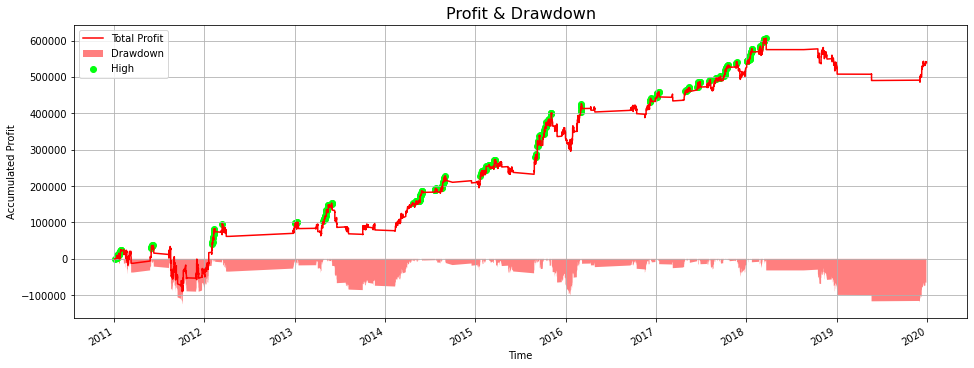

In [ ]:
# 未實現損益 performance
performance(equity, equity.index, equity['cum_profit'], buy, sell)

total return: $47.41%
annualized return: $4.97%
mdd: 12.65%
average holding period: 69.31 hours
calmar ratio: 3.75
sharpe ratio: 1.3391
win rate: 46.3%


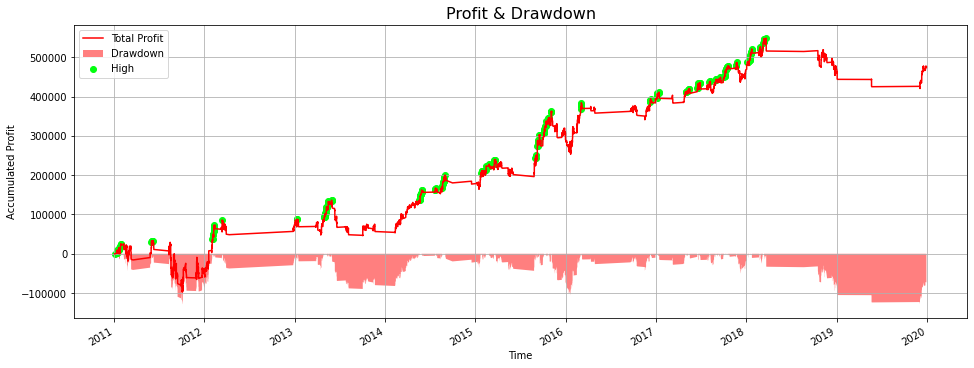

In [ ]:
# 未實現損益 performance
performance(equity, equity.index, equity['cum_profit_fee'], buy, sell)

## Strategy4: SAR + DMI

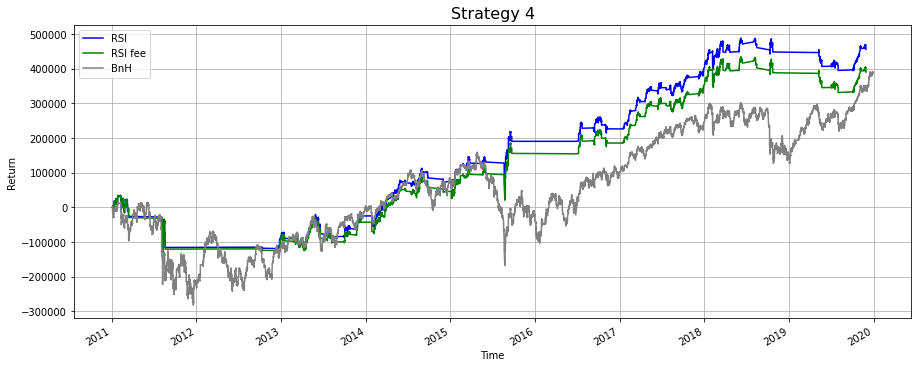

In [ ]:
# strategy3: RSI+SAR

first = 0 # 除了第一筆之外，只紀錄出場的時間點
BS = None # 紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0
temp_0 = 0

#--------# opt result
opt_acc = 0.0025
opt_low = 27
opt_up = 94 # not good

#--------# adding indicator
data_opt = df_Morning.copy()
data_opt['EMA'] = abstract.EMA(df_Morning, timeperiod = 900) 
data_opt['NDI'] = abstract.MINUS_DI(df_Morning, timeperiod = 7) # negative DI
data_opt['RSI'] = abstract.RSI(df_Morning, timeperiod = 14)
data_opt['RSI_MA'] = talib.SMA(data_opt['RSI'], timeperiod=14)
data_opt['MACD'] = abstract.MACD(df_Morning, fastperiod=11, slowperiod=40, signalperiod=9)['macd']
#========# 最佳化因子
opt_acc = 0.0025
data_opt['SAR'] = abstract.SAR(df_Morning, acceleration = opt_acc, maximum=0.20)
#========#
data_opt = data_opt.dropna()
trainData = data_opt[(data_opt.index >= '2011-01-01 00:00:00') & (data_opt.index <= '2019-12-31 00:00:00')].copy()




#--------# 設定進場標準
lower_bond = np.percentile(trainData['RSI'], opt_low)
upper_bond = np.percentile(trainData['RSI'], opt_up)
goal_NDI = np.percentile(trainData['NDI'], 97)

#--------# 記錄買入、賣出時間點
buy = []
sell = []
sell_win = []
sell_lose = []
M_point = []

#--------# 記錄報酬
timeList = [] 
profit_list = [0]
profit_fee_list = [0]



for i in range(len(trainData)):

    ###---Buy---###
    buy1 = (trainData['close'][i] > trainData['EMA'][i])
    buy2 = (trainData['NDI'][i] > goal_NDI)

    ###---turned---###
    
    # sar turnover => BS = 'T'
    turn = (trainData['SAR'][i] < trainData['close'][i])

    ###---sell---###

    # sell
    sell1 = (trainData['SAR'][i] > trainData['close'][i])
    sell2 = (trainData['RSI'][i] > upper_bond and trainData['RSI'][i] < trainData['RSI_MA'][i]) # not good

    # stop loss
    stop_loss1 = (trainData['close'][i] <= trainData['EMA'][i])
    # stop_loss2 = (trainData['close'][i] - temp_0)/temp_0 < -0.03

    # black swawn
    black_swawn = (trainData['MACD'][i] < -200)
    

    if first == 0:
        timeList.append(trainData.index[i+1])
        first = 1
        continue

    if i == len(trainData)-1: 
        break 

      # buy
    if buy1 and buy2 and BS == None:
        temp_0 = trainData['close'][i+1] 
        buy.append(i+1)
        BS = 'B'
        continue
  
      # sar turnover
    if turn and (BS == 'B'):
        BS = 'T' 
        continue

      # sell
    if (sell1) and (BS == 'T'):
        sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = None
        continue


     # sell_loss
    if stop_loss1 and (BS == 'T' or BS == 'B'): 
        sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = None
        continue

    ##### black_swawn #####
    if black_swawn and stop_loss1 and BS == None:
        M_point.append(i)
        BS = 'BS_R'

    if buy2 and BS == 'BS_R':
        temp_0 = trainData['close'][i+1] 
        buy.append(i+1)
        BS = 'BS_B'
        continue

    if turn and (BS == 'BS_B'):
        BS = 'BS_T' 

      # sell
    if (sell1) and (BS == 'BS_T'):
        sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = 'BS'
        continue
         
      # if back to > EMA
    if buy1 and (BS == 'BS' or BS == 'BS_R'):
        BS = None
        continue

    # if buy1 and (BS == 'BS_B'):
    #     BS = 'B'
    #     continue

    # if buy1 and (BS == 'BS_T'):
    #     BS = 'T'
    #     continue
        
    ##### black_swawn #####



      # record profit
    if BS == 'B' or BS == 'T' or BS == 'BS_B' or BS == 'BS_T':
        record_profit(trainData['close'][i+1], trainData['close'][i], trainData.index[i])

    
equity = pd.DataFrame({'profit':profit_list, 'cum_profit':np.cumsum(profit_list), 'profit_fee':profit_fee_list, 'cum_profit_fee':np.cumsum(profit_fee_list)}, index=timeList) 
dmiPro_equity = equity.copy()

# plot
equity['cum_profit'].plot(grid=True, label = 'RSI', c = 'b', figsize=(15, 6));
equity['cum_profit_fee'].plot(grid=True, label = 'RSI fee', c = 'g', figsize=(15, 6));
equity_bnh_train['cum_profit'].plot(grid=True, label = 'BnH', c = 'gray', figsize=(15, 6));

plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('Strategy 4',fontsize  = 16);

### 交易位置試算

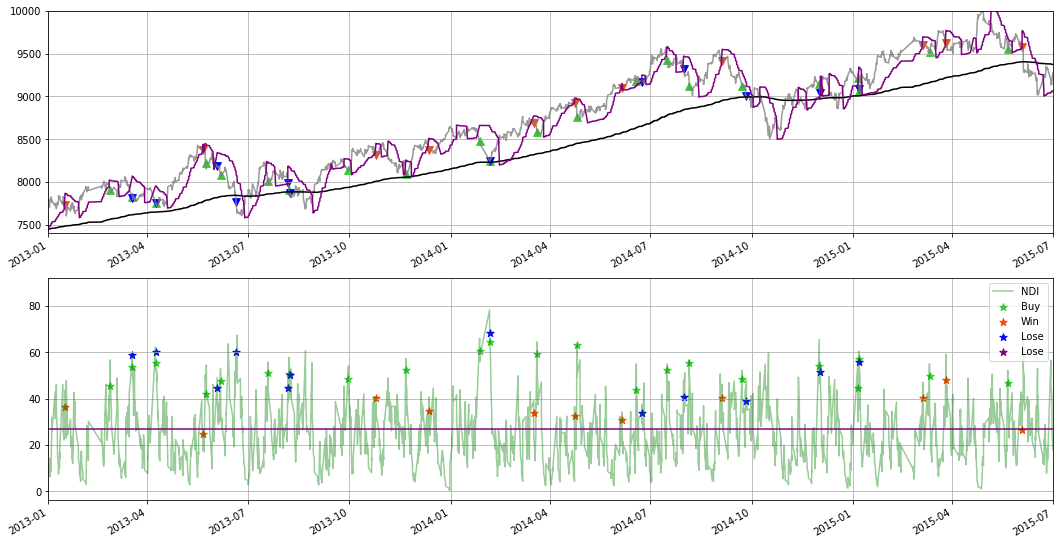

In [ ]:
# visualize trading position

fig, ax = plt.subplots(2, 1, figsize = (18,10))

a = 0
b = 1
# c = 2

# close a
trainData['close'].plot(label = 'close Price', ax = ax[a], c = 'gray', grid=True, alpha=0.8)
trainData['EMA'].plot(label = 'EMA', ax = ax[a], c = 'black', grid=True)
trainData['SAR'].plot(label = 'SAR', ax = ax[a], c = 'purple', grid=True)
ax[a].scatter(trainData['close'].iloc[buy].index, trainData['close'].iloc[buy], c = 'limegreen', label = 'Buy', marker='^', s=60)
ax[a].scatter(trainData['close'].iloc[sell_win].index, trainData['close'].iloc[sell_win], c = 'orangered', label = 'Win', marker='v', s=60)
ax[a].scatter(trainData['close'].iloc[sell_lose].index, trainData['close'].iloc[sell_lose], c = 'b', label = 'Lose', marker='v', s=60)
# ax[a].scatter(trainData['close'].iloc[sell_lose2].index, trainData['close'].iloc[sell_lose2], c = 'purple', label = 'Lose2', marker='v', s=60)


# DMI b
trainData['NDI'].plot(label = 'NDI', ax = ax[b], c = 'g', grid=True, alpha=0.4)
ax[b].scatter(trainData['close'].iloc[buy].index, trainData['NDI'].iloc[buy], c = 'limegreen', label = 'Buy', marker='*', s=60)
ax[b].scatter(trainData['close'].iloc[sell_win].index, trainData['NDI'].iloc[sell_win], c = 'orangered', label = 'Win', marker='*', s=60)
ax[b].scatter(trainData['close'].iloc[sell_lose].index, trainData['NDI'].iloc[sell_lose], c = 'b', label = 'Lose', marker='*', s=60)
ax[b].scatter(trainData['close'].iloc[sell_lose2].index, trainData['NDI'].iloc[sell_lose2], c = 'purple', label = 'Lose', marker='*', s=60)
ax[b].axhline(goal_ADX, c = 'purple')

# # MACD c
# trainData['MACD'].plot(label = 'MACD', ax = ax[c], c = 'black', grid=True)
# ax[c].axhline(y = 0)
# ax[c].scatter(trainData['close'].iloc[buy].index, trainData['MACD'].iloc[buy], c = 'limegreen', label = 'Buy', marker='*', s=60)
# ax[c].scatter(trainData['close'].iloc[sell_win].index, trainData['MACD'].iloc[sell_win], c = 'orangered', label = 'Win', marker='*', s=60)
# ax[c].scatter(trainData['close'].iloc[sell_lose].index, trainData['MACD'].iloc[sell_lose], c = 'b', label = 'Lose', marker='*', s=60)
# ax[c].scatter(trainData['close'].iloc[sell_lose2].index, trainData['MACD'].iloc[sell_lose2], c = 'purple', label = 'Lose', marker='*', s=60)


period = '2013-01-01', '2015-07-01'
price = 7400, 10000

ax[a].set_xlim(period)
ax[b].set_xlim(period)
# ax[c].set_xlim(period)

ax[a].set_ylim(price)
# ax[c].set_ylim(-200, 200)

plt.legend(loc = 'upper right')
# plt.ylabel('Index')
# plt.xlabel('Time')
# plt.title('Price Movement',fontsize  = 16)


In [ ]:
print('buy:{}'.format(len(buy)))
print('sell:{}'.format(len(sell)))
print('sellwin:{}'.format(len(sell_win)))
print('selllose:{}'.format(len(sell_lose)))
print('winlose_ratio:{}'.format(len(sell_win)/len(sell)))

buy:55
sell:55
sellwin:26
selllose:29
winlose_ratio:0.4727272727272727


total return: $45.6%
annualized return: $4.81%
mdd: 15.64%
average holding period: 64.2 hours
calmar ratio: 2.92
sharpe ratio: 0.9164
win rate: 47.27%


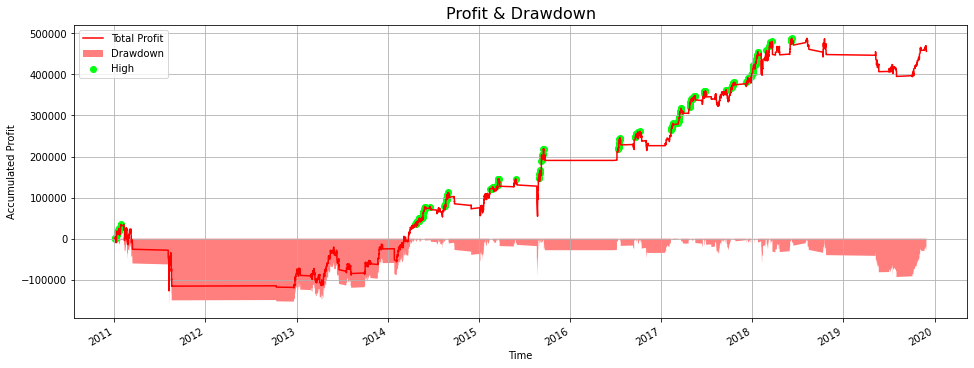

In [ ]:
performance(dmiPro_equity, dmiPro_equity.index, dmiPro_equity['cum_profit'], buy, sell)

total return: $39.0%
annualized return: $4.2%
mdd: 15.99%
average holding period: 64.2 hours
calmar ratio: 2.44
sharpe ratio: 0.8256
win rate: 47.27%


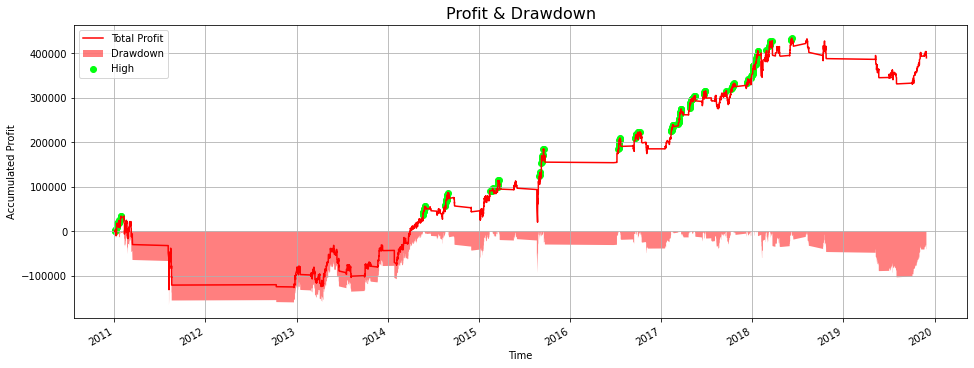

In [ ]:
performance(dmiPro_equity, dmiPro_equity.index, dmiPro_equity['cum_profit_fee'], buy, sell)

## compare

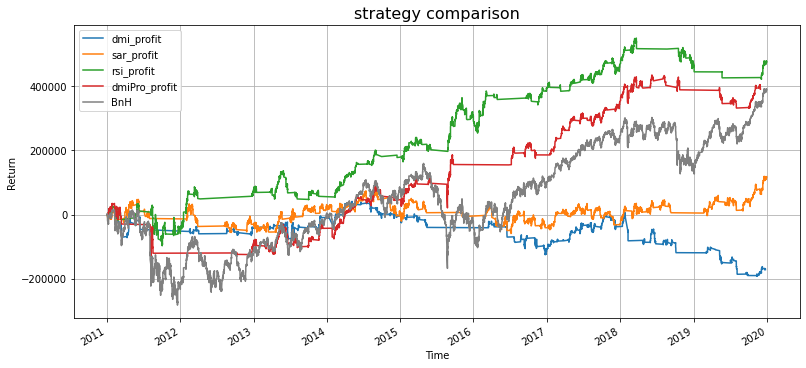

In [ ]:
dmi_equity['cum_profit_fee'].plot(label = 'dmi_profit', grid=True, figsize=(13, 6));
sar_equity['cum_profit_fee'].plot(label = 'sar_profit', grid=True, figsize=(13, 6));
rsi_equity['cum_profit_fee'].plot(label = 'rsi_profit', grid=True, figsize=(13, 6));
dmiPro_equity['cum_profit_fee'].plot(label = 'dmiPro_profit', grid=True, figsize=(13, 6));
equity_bnh_train['cum_profit'].plot(grid=True, label = 'BnH', c = 'gray', figsize=(13, 6));


plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('strategy comparison',fontsize  = 16);

# Strategy：做空

## 利潤設定

In [ ]:
def short_sell_profit(sell_price, buy_price, lastday_price, time):
  winLose = -(sell_price - buy_price)

  if winLose > 0:
    short_win.append(i+1)
  else:
    short_lose.append(i+1)
  
  profit = -money * ((sell_price - lastday_price) / lastday_price)
  profit_list.append(profit)
  profit_fee = profit - (money+profit) * feeRate - money * feeRate
  profit_fee_list.append(profit_fee)
  timeList.append(time)
  short_sell.append(i+1)


def short_record_profit(sell_price, lastday_price, time):
  profit = -money * ((sell_price - lastday_price)  / lastday_price)
  profit_list.append(profit)
  profit_fee_list.append(profit)
  timeList.append(time)

## Strategy1
* 進場條件
1. close < EMA
2. -150 < MACD < 0
3. close < SAR
* 出場條件
1. close > SAR
2. (獲利超過20%)
3. close > EMA
* 賺到大根的就出場：BS == 'M'

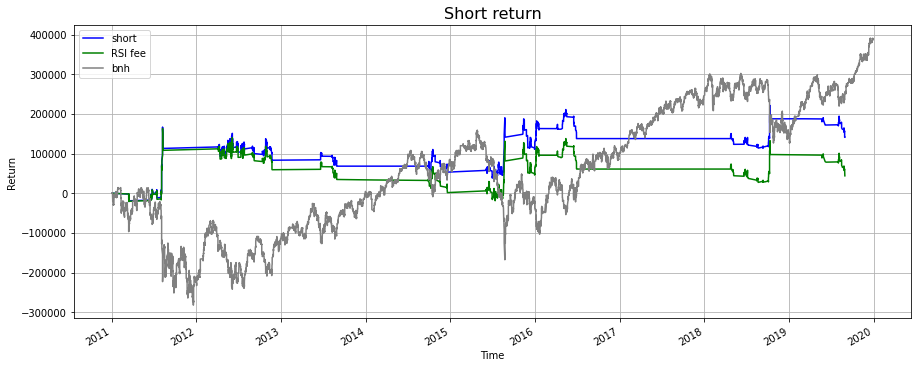

In [ ]:
first = 0 
BS = None 
stopEarn = 0
stopLoss = 0
temp_0 = 0


#--------# 重新載入訓練資料
trainData = data[(data.index >= '2011-01-01 00:00:00') & (data.index <= '2019-12-31 00:00:00')].copy()

#--------# 設定標準
goal_MACD = -200
goal_ADX = np.percentile(trainData['ADX'], 70)

#--------# 記錄買入、賣出時間點
short = []
short_sell = []
short_win = []
short_lose = []
short_lose2 = []

M_point = []

#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]



for i in range(len(trainData)):

    # short condition
    condition1 = (trainData['close'][i] < trainData['EMA'][i])
    condition2 = (-150 <trainData['MACD'][i] < 0) 
    condition3 = (trainData['close'][i] > trainData['EMA'][i])
    condition4 = (trainData['SAR'][i] > trainData['close'][i])
    # condition5 = (trainData['ADX'][i] > goal_ADX) 
    # condition6 = (trainData.index[i] not in settlementDate) 

    # stop earn condition
    stop_earn1 = (trainData['SAR'][i] <= trainData['close'][i]) # contain stoploss if profit <0

    # stop loss condition
    stop_loss1 = (trainData['close'][i] >= trainData['EMA'][i])

    # short M condition
    conditionM = (trainData['MACD'][i] < goal_MACD) 

    

    if first == 0:
        timeList.append(trainData.index[i+1])
        first = 1
        continue

      # last trading day
    if i == len(trainData)-1: 
        break
     
      # short
    if  condition1 and condition2 and condition4 and BS == None:
        BS = 'S' 
        temp_0 = trainData['open'][i+1] 
        short.append(i+1)
        continue

      # stop earn1
    if stop_earn1 and BS == 'S':
        short_sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = None
        continue

      # stop loss
    if stop_loss1 and BS == 'S':
        short_sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = None
        continue

      #-----change status : M-----#

    if conditionM and BS == 'S':
        short_record_profit(trainData['close'][i+1], trainData['close'][i], trainData.index[i]) 
        M_point.append(i)
        BS = 'M'
        continue

    
      # stop earn M
    if stop_earn1 and BS == 'M':
        short_sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = 'done'
        continue
        
      # change back to BS == None
    if condition3 and BS == 'done':
        BS = None
        continue

      #-----record profit-----#

    if BS == 'S' or BS == 'M':
        short_record_profit(trainData['close'][i+1], trainData['close'][i], trainData.index[i]) 
        continue

equity = pd.DataFrame({'profit':profit_list, 'cum_profit':np.cumsum(profit_list), 'profit_fee':profit_fee_list, 'cum_profit_fee':np.cumsum(profit_fee_list)}, index=timeList) 

short_equity = equity.copy()

# plot
equity['cum_profit'].plot(grid=True, label = 'short', c = 'blue', figsize=(15, 6));
equity['cum_profit_fee'].plot(grid=True, label = 'RSI fee', c = 'g', figsize=(15, 6));
equity_bnh_train['cum_profit'].plot(grid=True, label = 'bnh', c = 'gray', figsize=(15, 6));

plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('Short return',fontsize  = 16);

### 交易位置試算

In [ ]:
print('short:{}'.format(len(short)))
print('short_sell:{}'.format(len(short_sell)))
print('short_win:{}'.format(len(short_win)))
print('short_lose:{}'.format(len(short_lose)))
print('winlose_ratio:{}'.format(len(short_win)/len(short_sell)))


short:81
short_sell:81
short_win:22
short_lose:59
winlose_ratio:0.2716049382716049


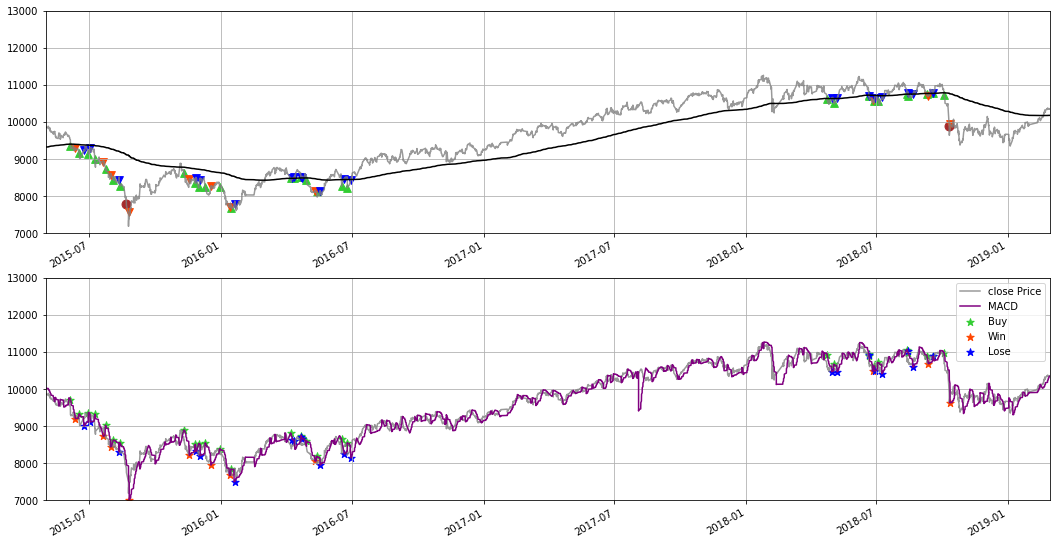

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (18,10))

a = 0
# c = 2
d = 1
# EMA a
trainData['close'].plot(label = 'close Price', ax = ax[a], c = 'gray', grid=True, alpha=0.8)
# trainData['SAR'].plot(label = 'MACD', ax = ax[a], c = 'purple', grid=True)
trainData['EMA'].plot(label = 'EMA', ax = ax[a], c = 'black', grid=True)
ax[a].scatter(trainData['close'].iloc[M_point].index, trainData['close'].iloc[M_point], c = 'brown', label = 'Buy', marker='o', s = 80)
ax[a].scatter(trainData['close'].iloc[short].index, trainData['close'].iloc[short], c = 'limegreen', label = 'Buy', marker='^', s=60)
ax[a].scatter(trainData['close'].iloc[short_win].index, trainData['close'].iloc[short_win], c = 'orangered', label = 'Win', marker='v', s=60)
ax[a].scatter(trainData['close'].iloc[short_lose].index, trainData['close'].iloc[short_lose], c = 'b', label = 'Lose', marker='v', s=60)
ax[a].scatter(trainData['close'].iloc[short_lose2].index, trainData['close'].iloc[short_lose2], c = 'y', label = 'Lose', marker='v', s=60)

# # MACD c
# trainData['MACD'].plot(label = 'MACD', ax = ax[c], c = 'black', grid=True)
# ax[c].axhline(y = 0)
# ax[c].scatter(trainData['close'].iloc[short].index, trainData['MACD'].iloc[short], c = 'limegreen', label = 'Buy', marker='*', s=60)
# ax[c].scatter(trainData['close'].iloc[short_win].index, trainData['MACD'].iloc[short_win], c = 'orangered', label = 'Win', marker='*', s=60)
# ax[c].scatter(trainData['close'].iloc[short_lose].index, trainData['MACD'].iloc[short_lose], c = 'b', label = 'Lose', marker='*', s=60)

# SAR d
trainData['close'].plot(label = 'close Price', ax = ax[d], c = 'gray', grid=True, alpha=0.8)
trainData['SAR'].plot(label = 'MACD', ax = ax[d], c = 'purple', grid=True)
ax[d].scatter(trainData['close'].iloc[short].index, trainData['SAR'].iloc[short], c = 'limegreen', label = 'Buy', marker='*', s=60)
ax[d].scatter(trainData['close'].iloc[short_win].index, trainData['SAR'].iloc[short_win], c = 'orangered', label = 'Win', marker='*', s=60)
ax[d].scatter(trainData['close'].iloc[short_lose].index, trainData['SAR'].iloc[short_lose], c = 'b', label = 'Lose', marker='*', s=60)


period = '2015-05-01', '2019-03-01'
price = 7000, 13000

ax[a].set_xlim(period)
ax[b].set_xlim(period)
ax[d].set_xlim(period)
ax[a].set_ylim(price)
ax[d].set_ylim(price)

plt.legend(loc = 'upper right')
# plt.ylabel('Index')
# plt.xlabel('Time')
# plt.title('Price Movement',fontsize  = 16)


total return: $14.11%
annualized return: $1.66%
mdd: 11.19%
average holding period: 64.2 hours
calmar ratio: 1.26
sharpe ratio: 2.1903
win rate: 47.27%


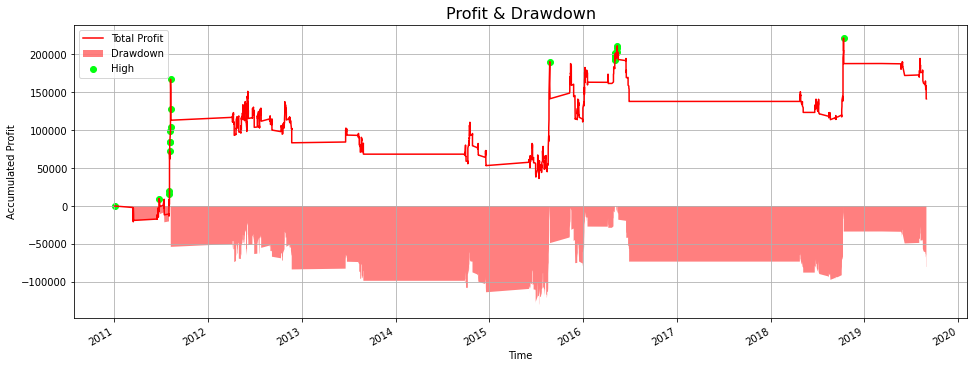

In [ ]:
# 未實現損益 performance
performance(equity, equity.index, equity['cum_profit'], buy, sell)

total return: $4.39%
annualized return: $0.54%
mdd: 15.66%
average holding period: 15.22 hours
calmar ratio: 0.28
sharpe ratio: 1.5068
win rate: 47.27%


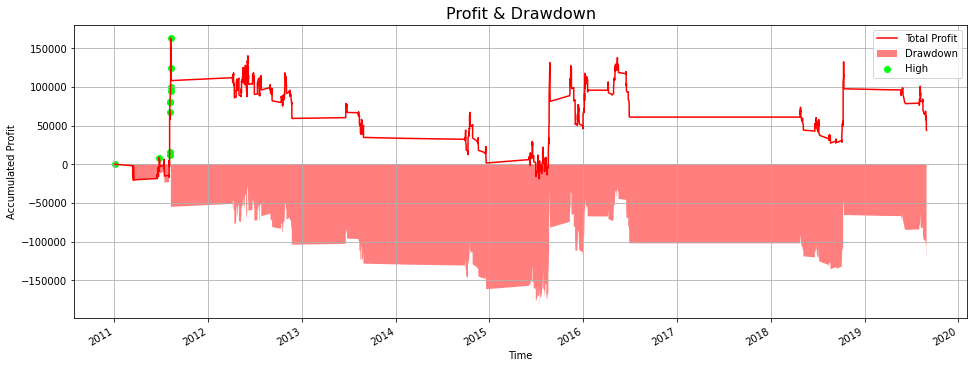

In [ ]:
# 已實現損益 performance
performance(short_equity, short_equity.index, short_equity['cum_profit_fee'], short, short_sell)

# 組合

<ipython-input-169-9297dcbc0126>:55: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ready4 = (trainData.index[i] not in settlementDate)


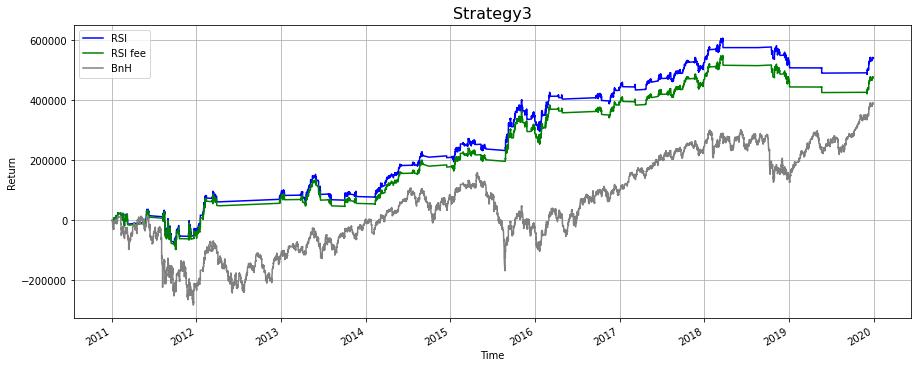

In [ ]:
# strategy3: RSI+SAR

first = 0 # 除了第一筆之外，只紀錄出場的時間點
BS = None # 紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0
temp_0 = 0

#--------# opt result
opt_acc = 0.0025
opt_low = 27
opt_up = 94 # not good

#--------# adding indicator
data_opt = df_Morning.copy()
data_opt['EMA'] = abstract.EMA(df_Morning, timeperiod = 900) 
data_opt['RSI'] = abstract.RSI(df_Morning, timeperiod = 14)
data_opt['RSI_MA'] = talib.SMA(data_opt['RSI'], timeperiod=14)
data_opt['MACD'] = abstract.MACD(df_Morning, fastperiod=11, slowperiod=40, signalperiod=9)['macd']
#========# 最佳化因子
opt_acc = 0.0025
data_opt['SAR'] = abstract.SAR(df_Morning, acceleration = opt_acc, maximum=0.20)
#========#
data_opt = data_opt.dropna()
trainData = data_opt[(data_opt.index >= '2011-01-01 00:00:00') & (data_opt.index <= '2019-12-31 00:00:00')].copy()




#--------# 設定進場標準
lower_bond = np.percentile(trainData['RSI'], opt_low)
upper_bond = np.percentile(trainData['RSI'], opt_up)

#--------# 記錄買入、賣出時間點
buy = []
sell = []
sell_win = []
sell_lose = []

#--------# 記錄報酬
timeList = [] 
profit_list = [0]
profit_fee_list = [0]



for i in range(len(trainData)):

    ###---Buy---###

    # buy ready
    ready1 = (trainData['RSI'][i] < lower_bond)
    ready2 = (trainData['RSI'][i] > trainData['RSI_MA'][i])
    ready3 = (trainData['close'][i] > trainData['EMA'][i])
    ready4 = (trainData.index[i] not in settlementDate)
    # buy 
    buy1 = (trainData['RSI'][i] >= lower_bond)


    ###---turned---###
    
    # sar turnover => BS = 'T'
    turn = (trainData['SAR'][i] < trainData['close'][i])

    ###---sell---###

    # sell
    sell1 = (trainData['SAR'][i] > trainData['close'][i])
    sell2 = (trainData['RSI'][i] > upper_bond and trainData['RSI'][i] < trainData['RSI_MA'][i]) # not good

    # stop loss
    stop_loss1 = (trainData['close'][i] <= trainData['EMA'][i])
    # stop_loss2 = (trainData['close'][i] - temp_0)/temp_0 < -0.03

    # black swawn
    black_swawn = (trainData['MACD'][i] < -200)



    if first == 0:
        timeList.append(trainData.index[i+1])
        first = 1
        continue

    if i == len(trainData)-1: 
        break 
     
      # ready to buy 
    if ready1 and ready2 and ready3 and ready4 and BS == None:
        BS = 'R' 
        continue 

      # buy
    if buy1 and BS == 'R':
        temp_0 = trainData['close'][i+1] 
        buy.append(i+1)
        BS = 'B'
        continue
  
      # sar turnover
    if turn and (BS == 'B'):
        BS = 'T' 
        continue

      # sell
    if (sell1) and (BS == 'T'):
        sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = None
        continue


     # sell_loss
    if stop_loss1 and (BS == 'T' or BS == 'B'): 
        sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = None
        continue

    ##### black_swawn #####
    if black_swawn and stop_loss1 and BS == None:
        BS = 'BS'

    if ready1 and ready2 and ready4 and BS == 'BS':
        BS = 'BS_R' 
        continue 

    if buy1 and BS == 'BS_R':
        temp_0 = trainData['close'][i+1] 
        buy.append(i+1)
        BS = 'BS_B'
        continue

    if turn and (BS == 'BS_B'):
        BS = 'BS_T' 

      # sell
    if (sell1) and (BS == 'BS_T'):
        sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = 'BS'
        continue
         
      # if back to > EMA
    if ready3 and (BS == 'BS' or BS == 'BS_R'):
        BS = None
        continue
        
    ##### black_swawn #####



      # record profit
    if BS == 'B' or BS == 'T' or BS == 'BS_B' or BS == 'BS_T':
        record_profit(trainData['close'][i+1], trainData['close'][i], trainData.index[i])

    
equity = pd.DataFrame({'profit':profit_list, 'cum_profit':np.cumsum(profit_list), 'profit_fee':profit_fee_list, 'cum_profit_fee':np.cumsum(profit_fee_list)}, index=timeList) 
rsi_equity = equity.copy()

# plot
equity['cum_profit'].plot(grid=True, label = 'RSI', c = 'b', figsize=(15, 6));
equity['cum_profit_fee'].plot(grid=True, label = 'RSI fee', c = 'g', figsize=(15, 6));
equity_bnh_train['cum_profit'].plot(grid=True, label = 'BnH', c = 'gray', figsize=(15, 6));

plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('Strategy3',fontsize  = 16);

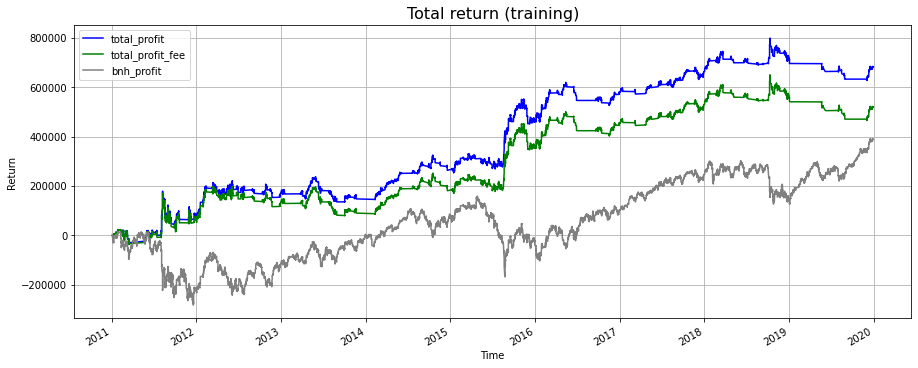

In [ ]:
# strategy3 + short
a = pd.merge(rsi_equity['cum_profit_fee'],short_equity['cum_profit_fee'],left_index = True, right_index = True, how='outer')
a.bfill(inplace = True)
a.ffill(inplace = True)
a['sum_fee'] = a['cum_profit_fee_x'] + a['cum_profit_fee_y']

total = pd.merge(rsi_equity['cum_profit'],short_equity['cum_profit'],left_index = True, right_index = True, how='outer')
total.bfill(inplace = True)
total.ffill(inplace = True)
total['sum'] = total['cum_profit_x'] + total['cum_profit_y']

total['sum_fee'] = a['sum_fee']

# plot
total['sum'].plot(label = 'total_profit', c = 'blue', grid=True, figsize=(15, 6));
total['sum_fee'].plot(label = 'total_profit_fee', c = 'green', grid=True, figsize=(15, 6));
equity_bnh_train['cum_profit'].plot(label = 'bnh_profit', c = 'gray', grid=True, figsize=(15, 6));

plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('Total return (training)',fontsize  = 16);

In [ ]:
total

,cum_profit_x,cum_profit_y,sum,sum_fee
2011-01-03 09:45:00,0.000000,0.000000,0.000000,0.000000
2011-01-11 09:45:00,1347.557552,-1960.784314,-613.226762,-613.226762
2011-01-11 10:45:00,2244.720275,-1960.784314,283.935961,283.935961
2011-01-11 11:45:00,4037.437362,-1960.784314,2076.653048,2076.653048
2011-01-11 12:45:00,7504.611056,-1960.784314,5543.826742,5543.826742
...,...,...,...,...
2019-12-27 12:45:00,542306.955800,141137.571374,683444.527174,521450.822116
2019-12-30 08:45:00,541233.462819,141137.571374,682371.034193,520377.329135
2019-12-30 09:45:00,541812.118684,141137.571374,682949.690058,520955.985000
2019-12-30 10:45:00,542059.970634,141137.571374,683197.542008,521203.836950


total return: $51.81%
annualized return: $5.36%
mdd: 13.3%
average holding period: 69.31 hours
calmar ratio: 3.89
sharpe ratio: 1.5864
win rate: 46.3%


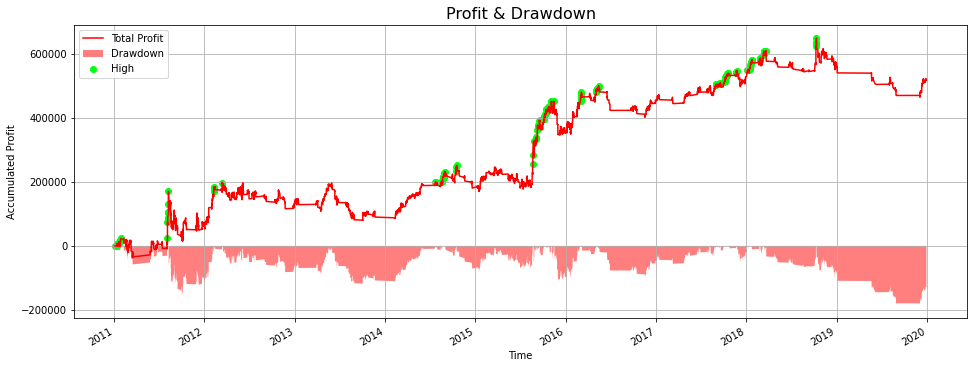

In [ ]:
performance(total, total.index, total['sum_fee'], buy, sell)

In [ ]:
# performance
total['equity'] = total['sum'] + fund
total['drawdown_percent'] = (total['equity'] / total['equity'].cummax()) - 1
total['drawdown'] = total['equity'] - total['equity'].cummax()

ret = (total['equity'].iloc[-1]/fund-1)
ann_ret = (1 + ret) ** (1/(total.index[-1].year - total.index[1].year)) - 1
total['drawdown_percent'] = (total['equity'] / total['equity'].cummax()) - 1
mdd = abs(total['drawdown_percent'].min())
mean_ret = total['sum'].mean()
std = total['sum'].std()

calmarRatio = ret / mdd
sharpe = total['sum'].mean() / total['sum'].std()
winRate = len(sell_win)/(len(sell_win) + len(sell_lose))

print(f'total return: ${np.round(ret * 100,2)}%')
print(f'annualized return: ${np.round(ann_ret * 100,2)}%')
print(f'mdd: {np.round(mdd * 100,2)}%')
print(f'calmar ratio: {np.round(calmarRatio,2)}')
print(f'sharpe ratio: {np.round(sharpe,4)}')

total return: $68.01%
annualized return: $6.7%
mdd: 12.9%
calmar ratio: 5.27
sharpe ratio: 1.6231


# Opt：做多
* 耗時，故先註解掉
* DMI strategy: DI => 15, ADX=>沒差


In [ ]:
# # 耗時，故先註解掉

# # DMI strategy optimizer
# # optimize ADX, NDI

# optimizationList = []

# # strategy 先暫時同除100比較好判斷
# fund = 100
# feePaid = 6
# money = 2 # 200 * 點數


# for DI_period in range(5, 51, 2):
#   #for ADX_period in range(10, 31, 2):

#     print('--------')
#     # print(f'ADX_period: {ADX_period}')
#     print(f'DI_period: {DI_period}')

#     first = 0 ##除了第一筆之外，只紀錄出場的時間點
#     BS = None ##紀錄現在的狀態是做多還做空
#     stopEarn = 0
#     stopLoss = 0
#     temp_0 = 0

#     #--------# adding indicator
#     data = df_Morning.copy()
#     data['EMA'] = abstract.EMA(df_Morning, timeperiod = 900) 
#     data['MACD'] = abstract.MACD(df_Morning, fastperiod=11, slowperiod=40, signalperiod=9)['macd']
#     data['SAR'] = abstract.SAR(df_Morning, acceleration=0.008, maximum=0.20)
#     #========# 最佳化因子
#     data['PDI'] = abstract.PLUS_DI(df_Morning, timeperiod = DI_period)
#     data['ADX'] = abstract.ADX(df_Morning, timeperiod = 14)
#     data['NDI'] = abstract.MINUS_DI(df_Morning, timeperiod = DI_period) 
#     #========#
#     data = data.dropna()
#     trainData = data[(data.index >= '2011-01-01 00:00:00') & (data.index <= '2019-12-31 00:00:00')].copy()

#     #--------# 標準
#     goal_NDI = np.percentile(trainData['NDI'], 80)
#     goal_ADX = np.percentile(trainData['ADX'], 50)

#     #--------# 記錄買入、賣出時間點
#     buy = []
#     sell = []
#     sell_win = []
#     sell_lose = []
#     sell_lose2 = []
#     #--------# 
#     timeList = [] 
#     profit_list = [0]
#     profit_fee_list = [0]

#     for i in range(len(trainData)):

#         # buy condition
#         condition1 = (trainData['NDI'][i] > goal_NDI)
#         condition2 = (trainData['ADX'][i] > goal_ADX)
#         condition3 = (BS == None) 
#         condition4 = (trainData['close'][i] > trainData['EMA'][i])
#         # condition6 = (trainData.index[i] not in settlementDate)


#         ###---stopearn_NDI---###
        
#         # ready
#         ready1 = (trainData['PDI'][i] > trainData['NDI'][i])
#         ready2 = (BS == 'B')

#         # stop earn
#         stop_earn1 = (trainData['NDI'][i] > trainData['PDI'][i])
#         stop_earn2 = (BS == 'Ready')

#         # stop loss
#         stop_loss1 = (trainData['close'][i] <= trainData['EMA'][i])
#         stop_loss2 = (trainData['close'][i] - temp_0)/temp_0 < -0.03
#         stop_loss3 = (BS == 'Ready' or BS == 'B')


#         if first == 0:
#             timeList.append(trainData.index[i+1])
#             first = 1
#             continue

#           # last trading day
#         if i == len(trainData)-1: 
#             break 
        
#           # buy 
#         if condition1 and condition2 and condition3 and condition4:
#             BS = 'B' 
#             temp_0 = trainData['close'][i+1] 
#             buy.append(i+1)
#             continue
      
#           # Ready
#         if ready1 and ready2:
#             BS = 'Ready' 

#           # sell 
#         if stop_earn1 and stop_earn2:
#             winLose = trainData['close'][i+1] - temp_0

#             if winLose > 0:
#               sell_win.append(i+1)
#             else:
#               sell_lose.append(i+1) 
            
#             profit = money * ((trainData['close'][i+1] - trainData['close'][i]) / trainData['close'][i])
#             profit_list.append(profit)
#             timeList.append(trainData.index[i])
          
#             sell.append(i+1)
#             BS = None
#             continue


#         # sell_loss: <3%
#         if stop_loss2 and stop_loss3: 
#             sell_lose2.append(i+1) 
#             profit = money * ((trainData['close'][i+1] - trainData['close'][i])  / trainData['close'][i])
#             profit_list.append(profit)
#             timeList.append(trainData.index[i])
#             # profit_fee = profit - feePaid * 2 # buy + sell
#             # profit_fee_list.append(profit_fee)

#             sell.append(i+1)
#             BS = None
#             continue
        
#           # record profit
#         if BS == 'B' or BS == 'Ready':

#             profit = money * ((trainData['close'][i+1] - trainData['close'][i])  / trainData['close'][i])
#             profit_list.append(profit)
#             profit_fee_list.append(profit)
#             timeList.append(trainData.index[i])
        
#     equity = pd.DataFrame({'profit':profit_list, 'cum_profit':np.cumsum(profit_list)}, index=timeList) #   'profit_fee':np.cumsum(profit_fee_list)
#     equity['equity'] = equity['profit'] + fund
#     ret = equity['equity'][-1]/equity['equity'][0] - 1
#     std = equity['profit'].std()
#     sharpe = ret/std

#     optimizationList.append([DI_period, ret, sharpe])

In [ ]:
# Opt = pd.DataFrame(optimizationList, columns = ['DI_period', 'return', 'sharpe_ratio'])
# Opt.sort_values('return', ascending = False).iloc[:5]

In [ ]:
# import seaborn as sns

# pic = Opt.pivot('ADX_period', 'DI_period', 'sharpe_ratio')
# sns.heatmap(data = pic).set(title = "sharpe_ratio")

* 期間：110
* 比率：0.85


## strategy3
* (upper: 87)
* lower: 27
* acc: 0.0025

In [ ]:
# # RSI+SAR strategy optimizer
# # optimize lower_bond, upper_bond

# optimizationList = []

# fund = 1000 # 全部資金
# # feePaid = 6 # 先不考慮手續費
# money = 1000 # 每次投入1000


# for acc in np.arange(0.001, 0.005, 0.0005):
#   for low in range(25, 33, 2):

#     print('--------')
#     print(f'SAR_acceleration: {acc}')
#     print(f'lower: {low}')
#     # print(f'upper: {up}')

#     first = 0 ##除了第一筆之外，只紀錄出場的時間點
#     BS = None ##紀錄現在的狀態是做多還做空
#     stopEarn = 0
#     stopLoss = 0
#     temp_0 = 0

#     #--------# adding indicator
#     data_opt = df_Morning.copy()
#     data_opt['EMA'] = abstract.EMA(df_Morning, timeperiod = 900) 
#     data_opt['RSI'] = abstract.RSI(df_Morning, timeperiod = 14)
#     data_opt['RSI_MA'] = talib.SMA(data_opt['RSI'], timeperiod=14)
#     #========# 最佳化因子
#     data_opt['SAR'] = abstract.SAR(df_Morning, acceleration = acc, maximum=0.20)
#     #========#
#     data_opt = data_opt.dropna()
#     trainData = data_opt[(data_opt.index >= '2011-01-01 00:00:00') & (data_opt.index <= '2019-12-31 00:00:00')].copy()


#     #--------# 設定進場標準
#     lower_bond = np.percentile(trainData['RSI'], low)
#     upper_bond = np.percentile(trainData['RSI'], 87)

#     #--------# 記錄買入、賣出時間點
#     buy = []
#     sell = []
#     sell_win = []
#     sell_lose = []

#     #--------# 記錄報酬
#     timeList = [] 
#     profit_list = [0]
#     profit_fee_list = [0]



#     for i in range(len(trainData)):

#         ###---Buy---###

#         # buy ready
#         ready1 = (trainData['RSI'][i] < lower_bond)
#         ready2 = (trainData['RSI'][i] > trainData['RSI_MA'][i])
#         ready3 = (trainData['close'][i] > trainData['EMA'][i])
#         ready4 = (trainData.index[i] not in settlementDate)
#         # buy 
#         buy1 = (trainData['RSI'][i] >= lower_bond)


#         ###---turned---###
        
#         # sar turnover => BS = 'T'
#         turn = (trainData['SAR'][i] < trainData['close'][i])

#         ###---sell---###

#         # sell
#         sell1 = (trainData['SAR'][i] > trainData['close'][i])
#         sell2 = (trainData['RSI'][i] > upper_bond and trainData['RSI'][i] < trainData['RSI_MA'][i])

#         # stop loss
#         stop_loss1 = (trainData['close'][i] <= trainData['EMA'][i])



#         if first == 0:
#             timeList.append(trainData.index[i+1])
#             first = 1
#             continue

#         if i == len(trainData)-1: 
#             break 
        
#           # ready to buy 
#         if ready1 and ready2 and ready3 and ready4 and BS == None:
#             BS = 'R' 
#             continue
          
#           # buy
#         if buy1 and BS == 'R':
#             temp_0 = trainData['close'][i+1] 
#             buy.append(i+1)
#             BS = 'B'
#             continue
      
#           # sar turnover
#         if turn and (BS == 'B'):
#             BS = 'T' 
#             continue

#           # sell
#         if (sell1) and (BS == 'T'):
#             winLose = trainData['close'][i+1] - temp_0

#             if winLose > 0:
#               sell_win.append(i+1)
#             else:
#               sell_lose.append(i+1) 
            
#             profit = money * ((trainData['close'][i+1] - trainData['close'][i]) / trainData['close'][i])
#             profit_list.append(profit)
#             timeList.append(trainData.index[i])
          
#             sell.append(i+1)
#             BS = None
#             continue


#         # sell_loss
#         if stop_loss1 and (BS == 'T' or BS == 'B'): 
#             winLose = trainData['close'][i+1] - temp_0

#             if winLose > 0:
#               sell_win.append(i+1)
#             else:
#               sell_lose.append(i+1) 
              
#             profit = money * ((trainData['close'][i+1] - trainData['close'][i])  / trainData['close'][i])
#             profit_list.append(profit)
#             timeList.append(trainData.index[i])

#             sell.append(i+1)
#             BS = None
#             continue
        
#           # record profit
#         if BS == 'B' or BS == 'T':

#             profit = money * ((trainData['close'][i+1] - trainData['close'][i])  / trainData['close'][i])
#             profit_list.append(profit)
#             timeList.append(trainData.index[i])
        
#     equity = pd.DataFrame({'profit':profit_list, 'cum_profit':np.cumsum(profit_list)}, index=timeList) 
#     equity['equity'] = equity['cum_profit'] + fund
#     ret = (equity['equity'][-1]/fund - 1) * 100
#     std = equity['profit'].std()
#     sharpe = ret/std

#     optimizationList.append([acc, low, ret, sharpe])

In [ ]:
# Opt = pd.DataFrame(optimizationList, columns = ['acc', 'low', 'return(%)', 'sharpe_ratio'])
# Opt.sort_values('return(%)', ascending = False).head(5)

In [ ]:
# import seaborn as sns

# pic = Opt.pivot('acc', 'low', 'return(%)')
# sns.heatmap(data = pic).set(title = "return(%)")

# Opt：做空
* 耗時，故先註解掉


In [ ]:
# df_Morning.info()

In [ ]:
# # Adding Indicator
# opt_train = df_Morning.copy()

# opt_train['ADX'] = abstract.ADX(df_Morning, timeperiod = 4)
# opt_train['PDI'] = abstract.PLUS_DI(df_Morning, timeperiod = 10) 
# opt_train['NDI'] = abstract.MINUS_DI(df_Morning, timeperiod = 10) 
# opt_train['EMA'] = abstract.EMA(df_Morning, timeperiod = 300) 

# # opt!!
# # opt_train['MACD'] = abstract.MACD(df_Morning, fastperiod=11, slowperiod=40, signalperiod=9)['macd']
# # opt_train['SAR'] = abstract.SAR(df_Morning, acceleration=0.01, maximum=0.20)

# # opt_train = opt_train.dropna()
# opt_train.info()

In [ ]:
# # only morning
# opt_train = df_Morning[(df_Morning.index >= '2011-01-01 00:00:00') & (df_Morning.index <= '2019-12-31 00:00:00')].copy()

In [ ]:
# # optimize MACD, SAR

# optimizationList = []

# # strategy 先暫時同除100比較好判斷
# fund = 10000
# # feePaid = 6
# money = 1000 # 每次投入1000

# # 放入其他indicator
# opt_train = df_Morning.copy()

# opt_train['NDI'] = abstract.MINUS_DI(opt_train, timeperiod = 10) 
# opt_train['EMA'] = abstract.EMA(opt_train, timeperiod = 300) 
# opt_train = opt_train.dropna()


# for signal_MACD in range(6, 21, 2):
#   for acc_SAR in np.arange(0.005, 0.021, 0.002):

#     print('--------')
#     print(f'signal_MACD: {signal_MACD}')
#     print(f'acc_SAR: {acc_SAR}')


#     opt_train['MACD'] = abstract.MACD(opt_train, fastperiod=11, slowperiod=40, signalperiod= signal_MACD)['macd']
#     opt_train['SAR'] = abstract.SAR(opt_train, acceleration= acc_SAR, maximum=0.20)

#     # only train
#     opt_train = opt_train[(opt_train.index >= '2011-01-01 00:00:00') & (opt_train.index <= '2019-12-31 00:00:00')]

#     first = 0 ##除了第一筆之外，只紀錄出場的時間點
#     BS = None ##紀錄現在的狀態是做多還做空
#     temp_0 = 0

#     #--------# 記錄買入、賣出時間點
#     short = []
#     short_sell = []
#     short_win = []
#     short_lose = []

#     #--------# 
#     timeList = [] 
#     profit_list = [0]
#     profit_fee_list = [0]


#     for i in range(len(opt_train)):

#         # short condition
#         condition1 = (opt_train['close'][i] < opt_train['EMA'][i])
#         condition2 = (opt_train['MACD'][i] > 0)
#         condition3 = (BS == None) and (opt_train.index[i] not in settlementDate)
#         condition4 = (opt_train['SAR'][i] > opt_train['close'][i])
#         # condition5 = (opt_train['MACD'][i] < opt_train['goal_MACD][i])

#         # stop earn condition
#         stop_earn1 = (opt_train['SAR'][i] <= opt_train['close'][i]) # contain stoploss if profit <0
#         # stop_earn2 = (opt_train['NDI'][i] >= opt_train['goal_NDI'][i]) # not so good

#         # stop loss condition
#         stop_loss1 = (opt_train['close'][i] >= opt_train['EMA'][i])
        

#         if first == 0:
#             timeList.append(opt_train.index[i+1])
#             first = 1
#             continue

#           # last trading day
#         if i == len(opt_train)-1: 
#             break
        
#           # short
#         if condition1 and condition2 and condition3 and condition4:
#             BS = 'S' 
#             temp_0 = opt_train['close'][i+1] 
#             short.append(i+1)
#             continue

#           # stop earn1
#         if stop_earn1 and BS=='S':
#             profit = money * ((opt_train['close'][i] - opt_train['close'][i+1]) / opt_train['close'][i])
#             profit_list.append(profit)
#             timeList.append(opt_train.index[i])

#             winLose = temp_0 - opt_train['close'][i+1]

#             if winLose > 0:
#                 short_win.append(i+1)
#             else:
#                 short_lose.append(i+1)
            
#             short_sell.append(i+1)
#             BS = None
#             continue


#           # stop earn2
#         # if stop_earn2 and BS=='S':
#         #     profit = money * ((opt_train['close'][i] - opt_train['close'][i+1]) / opt_train['close'][i])
#         #     profit_list.append(profit)
#         #     timeList.append(opt_train.index[i])
            
#         #     short_sell.append(i+1)
#         #     short_win.append(i+1)
#         #     BS = None
#         #     continue

#           # stop loss
#         if stop_loss1 and BS == 'S':
#             profit = money * ((opt_train['close'][i] - opt_train['close'][i+1]) / opt_train['close'][i])
#             profit_list.append(profit)
#             timeList.append(opt_train.index[i])
            
#             short_sell.append(i+1)
#             short_lose.append(i+1)
#             BS = None
#             continue

#           # record profit
#         if BS == 'S':
#             profit = money * ((opt_train['close'][i] - opt_train['close'][i+1])  / opt_train['close'][i])
#             profit_list.append(profit)
#             timeList.append(opt_train.index[i])
        
#     equity = pd.DataFrame({'profit':profit_list, 'cum_profit':np.cumsum(profit_list)}, index=timeList) 

#     equity['equity'] = equity['profit'] + fund
#     equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
#     equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
#     ret = equity['equity'][-1]/equity['equity'][0] - 1
#     mdd = abs(equity['drawdown_percent'].min())
#     std = equity['cum_profit'].std()
#     sharpe = ret/std
#     # calmarRatio = ret / mdd  

#     optimizationList.append([signal_MACD, acc_SAR, ret, sharpe])

In [ ]:
# equity['cum_profit'].plot()

In [ ]:
# Opt = pd.DataFrame(optimizationList, columns = ['signal_MACD', 'acc_SAR', 'return', 'sharpe_ratio'])
# Opt.sort_values('sharpe_ratio', ascending = True).iloc[:5]

In [ ]:
# import seaborn as sns

# pic = Opt.pivot('signal_MACD', 'acc_SAR', 'return')
# sns.heatmap(data = pic).set(title = "return")

# Testing data

In [ ]:
first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0
temp_0 = 0


#--------# 設定進場標準

# method 1
goal_NDI = np.percentile(testData['NDI'], 80)
goal_ADX = np.percentile(testData['ADX'], 50)

# method 2
# percent = 0.85
# rolling_period = 110
# testData['goal_NDI']  =  percent * testData['NDI'].rolling(rolling_period).mean()/0.5
# testData['goal_ADX'] = testData['ADX'].rolling(rolling_period).mean()
# testData = testData.bfill()

#--------# 記錄買入、賣出時間點
buy = []
sell = []
sell_win = []
sell_lose = []
sell_lose2 = []

#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]



for i in range(len(testData)):

    # buy condition
    condition1 = (testData['NDI'][i] > goal_NDI)
    condition2 = (testData['ADX'][i] > goal_ADX)
    condition3 = (BS == None) 
    condition4 = (testData['close'][i] > testData['EMA'][i])
    condition5 = (testData['SAR'][i] > testData['close'][i])
    condition6 = (testData.index[i] not in settlementDate)


    ###---stopearn_NDI---###
    
    # ready
    ready1 = (testData['PDI'][i] > testData['NDI'][i])
    ready2 = (BS == 'B')

    # stop earn
    stop_earn1 = (testData['NDI'][i] > testData['PDI'][i])
    stop_earn2 = (BS == 'Ready')

    # stop loss
    stop_loss1 = (testData['close'][i] <= testData['EMA'][i])
    

    ###---short inverse condition---###

    # condition1 = (testData['close'][i] > testData['EMA'][i])
    # condition2 = (150 > testData['MACD'][i] > 0)
    # condition3 = (BS == None)
    # condition4 = (testData['SAR'][i] < testData['close'][i])
    
    # stop earn condition
    # stop_earn1 = (testData['SAR'][i] >= testData['close'][i]) # contain stoploss if profit <0 

    # stop loss condition
    # stop_loss1 = (testData['close'][i] <= testData['EMA'][i])


    if first == 0:
        timeList.append(testData.index[i+1])
        first = 1
        continue

      # last trading day
    if i == len(testData)-1: 
        break 
    
      # buy 
    if condition2 and condition3 and condition4:
        BS = 'B' 
        temp_0 = testData['close'][i+1] 
        buy.append(i+1)
        continue


  
      # Ready
    if ready1 and ready2:
        BS = 'Ready' 

      # sell 
    if stop_earn1 and stop_earn2:
        winLose = testData['close'][i+1] - temp_0

        if winLose > 0:
          sell_win.append(i+1)
        else:
          sell_lose.append(i+1) 
        
        profit = money * ((testData['close'][i+1] - testData['close'][i]) / testData['close'][i])
        profit_list.append(profit)
        timeList.append(testData.index[i])
      
        sell.append(i+1)
        BS = None
        continue


    # sell_lose2 : <3%
    if (testData['close'][i] - temp_0)/temp_0 < -0.03 and (BS == 'Ready' or BS == 'B'): 
        sell_lose2.append(i+1) 
        profit = money * ((testData['close'][i+1] - testData['close'][i])  / testData['close'][i])
        profit_list.append(profit)
        timeList.append(testData.index[i])
        # profit_fee = profit - feePaid * 2 # buy + sell
        # profit_fee_list.append(profit_fee)

        sell.append(i+1)
        BS = None
        continue
    

      # record profit
    if BS == 'B' or BS == 'Ready':

        profit = money * ((testData['close'][i+1] - testData['close'][i])  / testData['close'][i])
        profit_list.append(profit)
        profit_fee_list.append(profit)
        timeList.append(testData.index[i])
    
equity = pd.DataFrame({'profit':profit_list, 'cum_profit':np.cumsum(profit_list)}, index=timeList) #   'profit_fee':np.cumsum(profit_fee_list)
dmi_equity_test = equity.copy()

<ipython-input-187-0a1603c05c2c>:43: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  condition6 = (testData.index[i] not in settlementDate)
<ipython-input-187-0a1603c05c2c>:115: RuntimeWarning: divide by zero encountered in double_scalars
  if (testData['close'][i] - temp_0)/temp_0 < -0.03 and (BS == 'Ready' or BS == 'B'):


<ipython-input-188-432d1c0e0425>:54: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ready4 = (trainData.index[i] not in settlementDate)


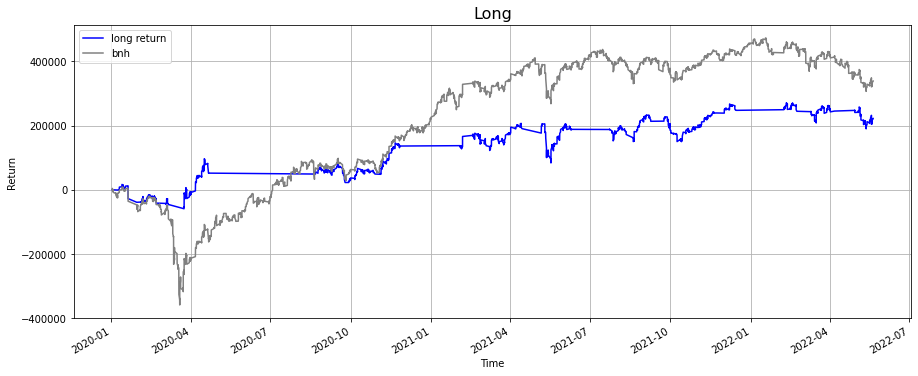

In [ ]:
# strategy3: RSI+SAR

first = 0 # 除了第一筆之外，只紀錄出場的時間點
BS = None # 紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0
temp_0 = 0

#--------# opt result
opt_acc = 0.0025
opt_low = 27
opt_up = 94 # not good

#--------# adding indicator
data_opt = df_Morning.copy()
data_opt['EMA'] = abstract.EMA(df_Morning, timeperiod = 900) 
data_opt['RSI'] = abstract.RSI(df_Morning, timeperiod = 14)
data_opt['RSI_MA'] = talib.SMA(data_opt['RSI'], timeperiod=14)
data_opt['MACD'] = abstract.MACD(df_Morning, fastperiod=11, slowperiod=40, signalperiod=9)['macd']
#========# 最佳化因子
opt_acc = 0.0025
data_opt['SAR'] = abstract.SAR(df_Morning, acceleration = opt_acc, maximum=0.20)
#========#
data_opt = data_opt.dropna()
trainData = data_opt[(data.index >= '2020-1-1 00:00:00') & (data.index <= '2022-5-22 00:00:00')].copy()



#--------# 設定進場標準
lower_bond = np.percentile(trainData['RSI'], opt_low)
upper_bond = np.percentile(trainData['RSI'], opt_up)

#--------# 記錄買入、賣出時間點
buy = []
sell = []
sell_win = []
sell_lose = []

#--------# 記錄報酬
timeList = [] 
profit_list = [0]
profit_fee_list = [0]



for i in range(len(trainData)):

    ###---Buy---###

    # buy ready
    ready1 = (trainData['RSI'][i] < lower_bond)
    ready2 = (trainData['RSI'][i] > trainData['RSI_MA'][i])
    ready3 = (trainData['close'][i] > trainData['EMA'][i])
    ready4 = (trainData.index[i] not in settlementDate)
    # buy 
    buy1 = (trainData['RSI'][i] >= lower_bond)


    ###---turned---###
    
    # sar turnover => BS = 'T'
    turn = (trainData['SAR'][i] < trainData['close'][i])

    ###---sell---###

    # sell
    sell1 = (trainData['SAR'][i] > trainData['close'][i])
    sell2 = (trainData['RSI'][i] > upper_bond and trainData['RSI'][i] < trainData['RSI_MA'][i]) # not good

    # stop loss
    stop_loss1 = (trainData['close'][i] <= trainData['EMA'][i])
    # stop_loss2 = (trainData['close'][i] - temp_0)/temp_0 < -0.03

    # black swawn
    black_swawn = (trainData['MACD'][i] < -200)



    if first == 0:
        timeList.append(trainData.index[i+1])
        first = 1
        continue

    if i == len(trainData)-1: 
        break 
     
      # ready to buy 
    if ready1 and ready2 and ready3 and ready4 and BS == None:
        BS = 'R' 
         

      # buy
    if buy1 and BS == 'R':
        temp_0 = trainData['close'][i+1] 
        buy.append(i+1)
        BS = 'B'
        continue
  
      # sar turnover
    if turn and (BS == 'B'):
        BS = 'T' 
        continue

      # sell
    if (sell1) and (BS == 'T'):
        winLose = trainData['close'][i+1] - temp_0

        if winLose > 0:
          sell_win.append(i+1)
        else:
          sell_lose.append(i+1) 
        
        profit = money * ((trainData['close'][i+1] - trainData['close'][i]) / trainData['close'][i])
        profit_list.append(profit)
        timeList.append(trainData.index[i])
       
        sell.append(i+1)
        BS = None
        continue


     # sell_loss
    if stop_loss1 and (BS == 'T' or BS == 'B'): 
        winLose = trainData['close'][i+1] - temp_0

        if winLose > 0:
          sell_win.append(i+1)
        else:
          sell_lose.append(i+1) 
          
        profit = money * ((trainData['close'][i+1] - trainData['close'][i])  / trainData['close'][i])
        profit_list.append(profit)
        timeList.append(trainData.index[i])

        sell.append(i+1)
        BS = None
        continue

    ##### black_swawn #####
    if black_swawn and stop_loss1 and BS == None:
        BS = 'BS'

    if ready1 and ready2 and ready4 and BS == 'BS':
        BS = 'BS_R' 
        continue 

    if buy1 and BS == 'BS_R':
        temp_0 = trainData['close'][i+1] 
        buy.append(i+1)
        BS = 'BS_B'
        continue

    if turn and (BS == 'BS_B'):
        BS = 'BS_T' 

      # sell
    if (sell1) and (BS == 'BS_T'):
        winLose = trainData['close'][i+1] - temp_0

        if winLose > 0:
          sell_win.append(i+1)
        else:
          sell_lose.append(i+1) 
        
        profit = money * ((trainData['close'][i+1] - trainData['close'][i]) / trainData['close'][i])
        profit_list.append(profit)
        timeList.append(trainData.index[i])
       
        sell.append(i+1)
        BS = 'BS'
        continue
         
      # if back to > EMA
    if ready3 and (BS == 'BS' or BS == 'BS_R'):
        BS = None
        continue
        
    ##### black_swawn #####



      # record profit
    if BS == 'B' or BS == 'T' or BS == 'BS_B' or BS == 'BS_T':

        profit = money * ((trainData['close'][i+1] - trainData['close'][i])  / trainData['close'][i])
        profit_list.append(profit)
        profit_fee_list.append(profit)
        timeList.append(trainData.index[i])
    
equity = pd.DataFrame({'profit':profit_list, 'cum_profit':np.cumsum(profit_list)}, index=timeList) 
rsi_equity_test = equity.copy()

# plot
equity['cum_profit'].plot(grid=True, label = 'long return', c = 'b', figsize=(15, 6));
equity_bnh_test['cum_profit'].plot(grid=True, label = 'bnh', c = 'gray', figsize=(15, 6));

plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('Long',fontsize  = 16);

In [ ]:
first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0
temp_0 = 0

#--------# 設定進場標準

# percent = 0.65
# rolling_period = 110
# testData['goal_NDI']  =  percent * testData['NDI'].rolling(rolling_period).mean()/0.5


# 不確定的濾網
# goal_MACD = 0.05
# testData['goal_MACD']  =  percent * testData['MACD'].rolling(rolling_period).mean()/0.5
# testData['goal_ADX'] = testData['ADX'].rolling(rolling_period).mean()

testData = testData.bfill()

#--------# 記錄買入、賣出時間點
short = []
short_sell = []
short_win = []
short_lose = []
short_lose2 = []

#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]



for i in range(len(testData)):

    # short condition
    condition1 = (testData['close'][i] < testData['EMA'][i])
    condition2 = (-150 <testData['MACD'][i] < 0) 
    condition3 = (BS == None)
    condition4 = (testData['SAR'][i] > testData['close'][i])
    # condition5 = (testData['NDI'][i] > testData['goal_NDI'][i]) 
    # condition6 = (testData['MACD'][i] < testData['goal_MACD][i])
    # condition7 = (testData.index[i] not in settlementDate) 

    # stop earn condition
    stop_earn1 = (testData['SAR'][i] <= testData['close'][i]) # contain stoploss if profit <0
    # stop_earn2 = (((testData['close'][i+1] - testData['close'][i]) / testData['close'][i]) > 0.2 ) # > 20% 

    # stop loss condition
    stop_loss1 = (testData['close'][i] >= testData['EMA'][i])
    

    if first == 0:
        timeList.append(testData.index[i+1])
        first = 1
        continue

      # last trading day
    if i == len(testData)-1: 
        break
    
      # short
    if  condition1 and condition2 and condition3 and condition4 :
        BS = 'S' 
        temp_0 = testData['close'][i+1] 
        short.append(i+1)
        continue

      # stop earn1
    if stop_earn1 and BS=='S':
        profit = money * ((testData['close'][i] - testData['close'][i+1]) / testData['close'][i])
        profit_list.append(profit)
        timeList.append(testData.index[i])

        winLose = temp_0 - testData['close'][i+1]

        if winLose > 0:
            short_win.append(i+1)
        else:
            short_lose.append(i+1)
        
        short_sell.append(i+1)
        BS = None
        continue


      # stop earn2
    # if stop_earn2 and BS=='S':
    #     profit = money * ((testData['close'][i] - testData['close'][i+1]) / testData['close'][i])
    #     profit_list.append(profit)
    #     timeList.append(testData.index[i])
        
    #     short_sell.append(i+1)
    #     short_win.append(i+1)
    #     BS = None
    #     continue

      # stop loss
    if stop_loss1 and BS == 'S':
        profit = money * ((testData['close'][i] - testData['close'][i+1]) / testData['close'][i])
        profit_list.append(profit)
        timeList.append(testData.index[i])
        
        short_sell.append(i+1)
        short_lose2.append(i+1)
        BS = None
        continue

      # record profit
    if BS == 'S':
        profit = money * ((testData['close'][i] - testData['close'][i+1])  / testData['close'][i])
        profit_list.append(profit)
        timeList.append(testData.index[i])
    
equity = pd.DataFrame({'profit':profit_list, 'cum_profit':np.cumsum(profit_list)}, index=timeList) 
short_equity_test = equity.copy()

# testing data results

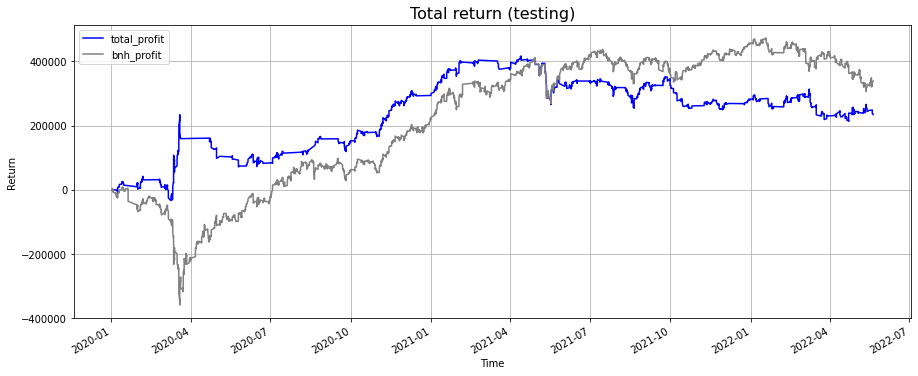

In [ ]:
total = pd.merge(dmi_equity_test['cum_profit'],short_equity_test['cum_profit'],left_index = True, right_index = True, how='outer')
total = total.ffill()
total['sum'] = total['cum_profit_x'] + total['cum_profit_y']

# plot
total['sum'].plot(label = 'total_profit', c = 'blue', grid=True, figsize=(15, 6));
equity_bnh_test['cum_profit'].plot(label = 'bnh_profit', c = 'gray', grid=True, figsize=(15, 6));

plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('Total return (testing)',fontsize  = 16);

In [ ]:
# performance
total['equity'] = total['sum'] + fund
total['drawdown_percent'] = (total['equity'] / total['equity'].cummax()) - 1
total['drawdown'] = total['equity'] - total['equity'].cummax()

ret = (total['equity'].iloc[-1]/fund-1)
ann_ret = (1 + ret) ** (1/(total.index[-1].year - total.index[1].year)) - 1
total['drawdown_percent'] = (total['equity'] / total['equity'].cummax()) - 1
mdd = abs(total['drawdown_percent'].min())
mean_ret = total['sum'].mean()
std = total['sum'].std()

calmarRatio = ret / mdd
sharpe = total['sum'].mean() / total['sum'].std()
winRate = len(sell_win)/(len(sell_win) + len(sell_lose))

print(f'total return: ${np.round(ret * 100,2)}%')
print(f'annualized return: ${np.round(ann_ret * 100,2)}%')
print(f'mdd: {np.round(mdd * 100,2)}%')
print(f'calmar ratio: {np.round(calmarRatio,2)}')
print(f'sharpe ratio: {np.round(sharpe,4)}')

total return: $23.46%
annualized return: $11.11%
mdd: 14.36%
calmar ratio: 1.63
sharpe ratio: 2.3408


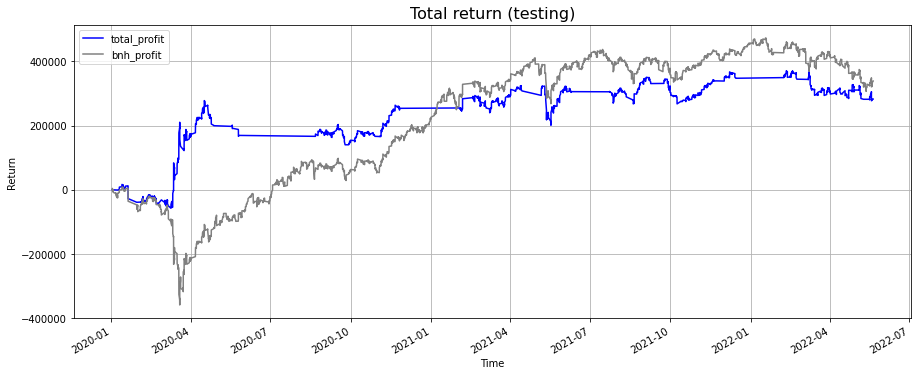

In [ ]:
# strategy3
total = pd.merge(rsi_equity_test['cum_profit'],short_equity_test['cum_profit'],left_index = True, right_index = True, how='outer')
total = total.ffill()
total['sum'] = total['cum_profit_x'] + total['cum_profit_y']

# plot
total['sum'].plot(label = 'total_profit', c = 'blue', grid=True, figsize=(15, 6));
equity_bnh_test['cum_profit'].plot(label = 'bnh_profit', c = 'gray', grid=True, figsize=(15, 6));

plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('Total return (testing)',fontsize  = 16);

# All

<ipython-input-193-8cad40dd32f8>:55: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ready4 = (trainData.index[i] not in settlementDate)


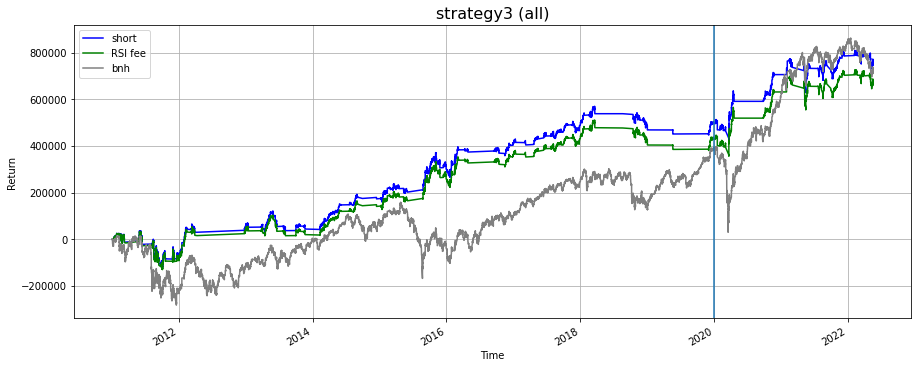

In [ ]:
# strategy3: RSI+SAR

first = 0 # 除了第一筆之外，只紀錄出場的時間點
BS = None # 紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0
temp_0 = 0

#--------# opt result
opt_acc = 0.0025
opt_low = 27
opt_up = 94 # not good

#--------# adding indicator
data_opt = df_Morning.copy()
data_opt['EMA'] = abstract.EMA(df_Morning, timeperiod = 900) 
data_opt['RSI'] = abstract.RSI(df_Morning, timeperiod = 14)
data_opt['RSI_MA'] = talib.SMA(data_opt['RSI'], timeperiod=14)
data_opt['MACD'] = abstract.MACD(df_Morning, fastperiod=11, slowperiod=40, signalperiod=9)['macd']
#========# 最佳化因子
opt_acc = 0.0025
data_opt['SAR'] = abstract.SAR(df_Morning, acceleration = opt_acc, maximum=0.20)
#========#
data_opt = data_opt.dropna()
trainData = data_opt[(data_opt.index >= '2011-01-01 00:00:00') & (data_opt.index <= '2022-05-22 00:00:00')].copy()




#--------# 設定進場標準
lower_bond = np.percentile(trainData['RSI'], opt_low)
upper_bond = np.percentile(trainData['RSI'], opt_up)

#--------# 記錄買入、賣出時間點
buy = []
sell = []
sell_win = []
sell_lose = []

#--------# 記錄報酬
timeList = [] 
profit_list = [0]
profit_fee_list = [0]



for i in range(len(trainData)):

    ###---Buy---###

    # buy ready
    ready1 = (trainData['RSI'][i] < lower_bond)
    ready2 = (trainData['RSI'][i] > trainData['RSI_MA'][i])
    ready3 = (trainData['close'][i] > trainData['EMA'][i])
    ready4 = (trainData.index[i] not in settlementDate)
    # buy 
    buy1 = (trainData['RSI'][i] >= lower_bond)


    ###---turned---###
    
    # sar turnover => BS = 'T'
    turn = (trainData['SAR'][i] < trainData['close'][i])

    ###---sell---###

    # sell
    sell1 = (trainData['SAR'][i] > trainData['close'][i])
    sell2 = (trainData['RSI'][i] > upper_bond and trainData['RSI'][i] < trainData['RSI_MA'][i]) # not good

    # stop loss
    stop_loss1 = (trainData['close'][i] <= trainData['EMA'][i])
    # stop_loss2 = (trainData['close'][i] - temp_0)/temp_0 < -0.03

    # black swawn
    black_swawn = (trainData['MACD'][i] < -200)



    if first == 0:
        timeList.append(trainData.index[i+1])
        first = 1
        continue

    if i == len(trainData)-1: 
        break 
      # ready to buy 
    if ready1 and ready2 and ready3 and ready4 and BS == None:
        BS = 'R' 
        continue 

      # buy
    if buy1 and BS == 'R':
        temp_0 = trainData['close'][i+1] 
        buy.append(i+1)
        BS = 'B'
        continue
  
      # sar turnover
    if turn and (BS == 'B'):
        BS = 'T' 
        continue

      # sell
    if (sell1) and (BS == 'T'):
        sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = None
        continue


     # sell_loss
    if stop_loss1 and (BS == 'T' or BS == 'B'): 
        sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = None
        continue

    ##### black_swawn #####
    if black_swawn and stop_loss1 and BS == None:
        BS = 'BS'

    if ready1 and ready2 and ready4 and BS == 'BS':
        BS = 'BS_R' 
        continue 

    if buy1 and BS == 'BS_R':
        temp_0 = trainData['close'][i+1] 
        buy.append(i+1)
        BS = 'BS_B'
        continue

    if turn and (BS == 'BS_B'):
        BS = 'BS_T' 

      # sell
    if (sell1) and (BS == 'BS_T'):
        sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = 'BS'
        continue
         
      # if back to > EMA
    if ready3 and (BS == 'BS' or BS == 'BS_R'):
        BS = None
        continue
        
    ##### black_swawn #####



      # record profit
    if BS == 'B' or BS == 'T' or BS == 'BS_B' or BS == 'BS_T':
        record_profit(trainData['close'][i+1], trainData['close'][i], trainData.index[i])

    
equity = pd.DataFrame({'profit':profit_list, 'cum_profit':np.cumsum(profit_list), 'profit_fee':profit_fee_list, 'cum_profit_fee':np.cumsum(profit_fee_list)}, index=timeList) 
rsi_equity_all = equity.copy()

# plot
equity['cum_profit'].plot(grid=True, label = 'short', c = 'blue', figsize=(15, 6));
equity['cum_profit_fee'].plot(grid=True, label = 'RSI fee', c = 'g', figsize=(15, 6));
equity_bnh_all['cum_profit'].plot(grid=True, label = 'bnh', c = 'gray', figsize=(15, 6));
plt.axvline(x = '2020-01-01')


plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('strategy3 (all)',fontsize  = 16);

total return: $67.75%
annualized return: $4.82%
mdd: 15.82%
average holding period: 69.46 hours
calmar ratio: 4.28
sharpe ratio: 1.2886
win rate: 47.89%


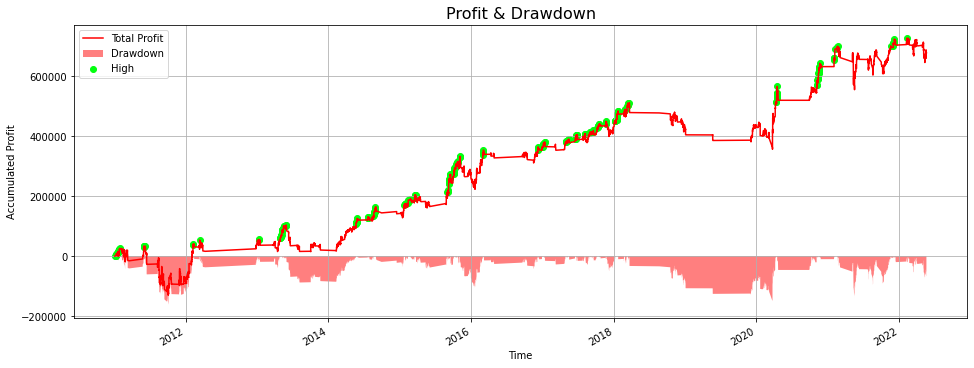

In [ ]:
performance(rsi_equity_all, rsi_equity_all.index, rsi_equity_all['cum_profit_fee'], buy, sell)

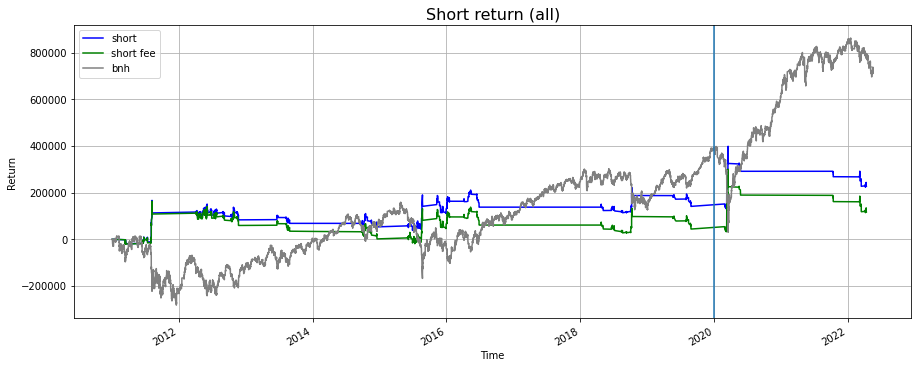

In [ ]:
first = 0 
BS = None 
stopEarn = 0
stopLoss = 0
temp_0 = 0


#--------# 重新載入訓練資料
trainData = totalData.copy()

#--------# 設定標準
goal_MACD = -200
goal_ADX = np.percentile(trainData['ADX'], 70)

#--------# 記錄買入、賣出時間點
short = []
short_sell = []
short_win = []
short_lose = []
short_lose2 = []

M_point = []

#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]



for i in range(len(trainData)):

    # short condition
    condition1 = (trainData['close'][i] < trainData['EMA'][i])
    condition2 = (-150 <trainData['MACD'][i] < 0) 
    condition3 = (trainData['close'][i] > trainData['EMA'][i])
    condition4 = (trainData['SAR'][i] > trainData['close'][i])
    # condition5 = (trainData['ADX'][i] > goal_ADX) 
    # condition6 = (trainData.index[i] not in settlementDate) 

    # stop earn condition
    stop_earn1 = (trainData['SAR'][i] <= trainData['close'][i]) # contain stoploss if profit <0

    # stop loss condition
    stop_loss1 = (trainData['close'][i] >= trainData['EMA'][i])

    # short M condition
    conditionM = (trainData['MACD'][i] < goal_MACD) 

    

    if first == 0:
        timeList.append(trainData.index[i+1])
        first = 1
        continue

      # last trading day
    if i == len(trainData)-1: 
        break
     
      # short
    if  condition1 and condition2 and condition4 and BS == None:
        BS = 'S' 
        temp_0 = trainData['open'][i+1] 
        short.append(i+1)
        continue

      # stop earn1
    if stop_earn1 and BS == 'S':
        short_sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = None
        continue

      # stop loss
    if stop_loss1 and BS == 'S':
        short_sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = None
        continue

      #-----change status : M-----#

    if conditionM and BS == 'S':
        short_record_profit(trainData['close'][i+1], trainData['close'][i], trainData.index[i]) 
        M_point.append(i)
        BS = 'M'
        continue

    
      # stop earn M
    if stop_earn1 and BS == 'M':
        short_sell_profit(trainData['open'][i+1], temp_0, trainData['close'][i], trainData.index[i])
        BS = 'done'
        continue
        
      # change back to BS == None
    if condition3 and BS == 'done':
        BS = None
        continue

      #-----record profit-----#

    if BS == 'S' or BS == 'M':
        short_record_profit(trainData['close'][i+1], trainData['close'][i], trainData.index[i]) 
        continue

equity = pd.DataFrame({'profit':profit_list, 'cum_profit':np.cumsum(profit_list), 'profit_fee':profit_fee_list, 'cum_profit_fee':np.cumsum(profit_fee_list)}, index=timeList) 

short_equity_all = equity.copy()

# plot
equity['cum_profit'].plot(grid=True, label = 'short', c = 'blue', figsize=(15, 6));
equity['cum_profit_fee'].plot(grid=True, label = 'short fee', c = 'g', figsize=(15, 6));
equity_bnh_all['cum_profit'].plot(grid=True, label = 'bnh', c = 'gray', figsize=(15, 6));
plt.axvline(x = '2020-01-01')


plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('Short return (all)',fontsize  = 16);

total return: $11.76%
annualized return: $1.02%
mdd: 15.66%
average holding period: 14.71 hours
calmar ratio: 0.75
sharpe ratio: 1.4298
win rate: 47.89%


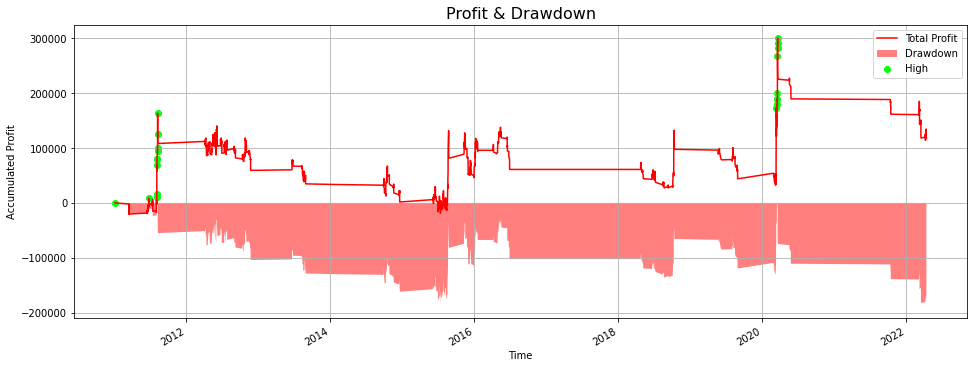

In [ ]:
performance(short_equity_all, short_equity_all.index, short_equity_all['cum_profit_fee'], short, short_sell, short_win, short_lose)

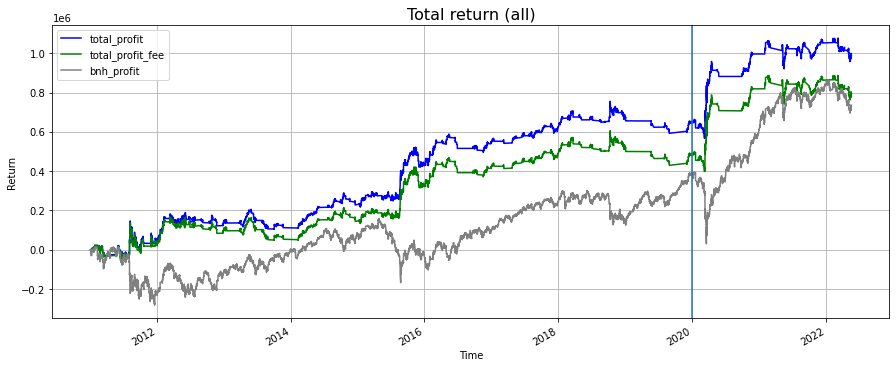

In [ ]:
# strategy3 + short
a = pd.merge(rsi_equity_all['cum_profit_fee'],short_equity_all['cum_profit_fee'],left_index = True, right_index = True, how='outer')
a.bfill(inplace = True)
a.ffill(inplace = True)
a['sum_fee'] = a['cum_profit_fee_x'] + a['cum_profit_fee_y']

total = pd.merge(rsi_equity_all['cum_profit'],short_equity_all['cum_profit'],left_index = True, right_index = True, how='outer')
total.bfill(inplace = True)
total.ffill(inplace = True)
total['sum'] = total['cum_profit_x'] + total['cum_profit_y']

total['sum_fee'] = a['sum_fee']

# plot
total['sum'].plot(label = 'total_profit', c = 'blue', grid=True, figsize=(15, 6));
total['sum_fee'].plot(label = 'total_profit_fee', c = 'green', grid=True, figsize=(15, 6));
equity_bnh_all['cum_profit'].plot(label = 'bnh_profit', c = 'gray', grid=True, figsize=(15, 6));
plt.axvline(x = '2020-01-01')

plt.legend()
plt.ylabel('Return')
plt.xlabel('Time')
plt.title('Total return (all)',fontsize  = 16);

total return: $79.51%
annualized return: $5.46%
mdd: 13.63%
average holding period: 69.46 hours
calmar ratio: 5.83
sharpe ratio: 1.3625
win rate: 47.89%


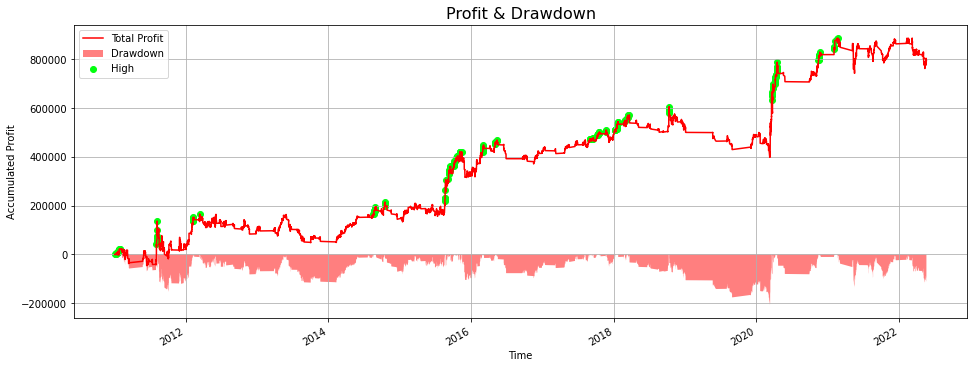

In [ ]:
performance(total, total.index, total['sum_fee'], buy, sell)

# End